# MRS Algorithm

To allow statistical inference in social sciences, survey participants must be selected at random
from the target population. When samples are drawn from parts of the population that are
close to hand, subgroups might be over-represented. This leads to statistical analyses under
sampling bias, which in turn may produce similarly biased outcomes. This notebook uses machine learning to reduce this selection bias in a psychological survey (**GBS**) using auxiliary information (**GESIS**/**Allensbach**) from comparable studies that are known to be representative. The proposed algorithm is first tested on US national Census data.

In [1]:
import random
import os
import pickle
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
import scipy.stats as stats
from pathlib import Path
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from scipy.spatial.distance import pdist
from tqdm.auto import tqdm

path = Path(os.getcwd()).parent

In [3]:
def plot_auc_median(auc_score, std_aucs, drop, file_name, number_of_samples, 
                    save, mrs_iterations):
    aucs_upper = np.minimum(auc_score + std_aucs, 1)
    aucs_younger = np.maximum(auc_score - std_aucs, 0)
    x_labels = range(number_of_samples, drop, -drop)
    plt.fill_between(x_labels, aucs_younger, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score, color='blue', label='Median AUROC',  linestyle='-')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Random')
    plt.ylabel('AUROC')
    mrs_iterations = number_of_samples - np.array(mrs_iterations)
    minimum = min(0.5, np.min(aucs_younger))
    maximum = plt.gca().get_ylim()[1]
    plt.margins(0.05, 0)
    plt.vlines(mrs_iterations, minimum, maximum, colors='black', linestyles='solid')
    plt.xticks(list(range(number_of_samples, 0, -100)) + [0])
    plt.gca().invert_xaxis()
    plt.xlabel('Number of remaining samples')
    xlim = plt.gca().get_xlim()
    ax2 = plt.gca().twiny()
    ax2.set_xlim(xlim)
    plt.xticks(list(mrs_iterations))
    [tick.set_color("blue") for tick in plt.gca().get_xticklabels()]
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

    
def plot_auc(auc_score, drop, file_name, number_of_samples, save=False, mrs_iterations=None):
    x_labels = range(number_of_samples, 0, -drop)
    plt.plot(x_labels, auc_score, color='blue', linestyle='-', label='AUROC')
    plt.plot((len(x_labels)-1)*drop *[0.5], color='black', linestyle='--', label='Random')
    plt.ylabel('AUROC')

    mrs_iterations = number_of_samples - np.array(mrs_iterations)
    minimum = min(0.5, np.min(auc_score))
    maximum = plt.gca().get_ylim()[1]
    plt.margins(0.05, 0)
    plt.vlines(mrs_iterations, minimum, maximum, colors='black', linestyles='solid')
    plt.xticks(list(range(number_of_samples, 0, -500)) + [0])
    plt.gca().invert_xaxis()
    plt.xlabel('Number of remaining samples')
    xlim = plt.gca().get_xlim()
    ax2 = plt.gca().twiny()
    ax2.set_xlim(xlim)
    plt.xticks([mrs_iterations])
    [tick.set_color("blue") for tick in plt.gca().get_xticklabels()]
    
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

def plot_rocs(rocs, file_name,  save=False):
    default_cycle = (cycler('linestyle',[':','-.', (0, (3, 5, 1, 5, 1, 5)), '-',]) +
                    cycler(color=['blue', 'orange', 'orangered', 'cyan']))
    plt.rc('')
    plt.rc('axes', prop_cycle=default_cycle)
    for fper, tper, std, deleted_elements in rocs:
        tpfrs_higher = np.minimum(tper + std, 1)
        tpfrs_lower = np.maximum(tper - std, 0)
        plt.plot(fper, tper, label=f'{int(deleted_elements[0])} samples removed')
        plt.fill_between(fper, tpfrs_lower, tpfrs_higher, alpha=0.2)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random', linewidth=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds(mmds, drop, mmd_iteration, file_name, mrs_iterations, number_of_samples, save=False):
    x_labels = range(number_of_samples, 0, -drop * mmd_iteration)
    plt.plot(x_labels, mmds, linestyle='-')
    minimum =  np.min(mmds)
    maximum = plt.gca().get_ylim()[1]
    plt.margins(0.05, 0)
    mrs_iterations = number_of_samples - np.array(mrs_iterations)
    plt.vlines(mrs_iterations, minimum, maximum, colors='black', linestyles='solid')
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of remaining samples')
    plt.xticks(list(range(number_of_samples, 0, -500)) + [0])
    plt.gca().invert_xaxis()
    xlim = plt.gca().get_xlim()
    ax2 = plt.gca().twiny()
    ax2.set_xlim(xlim)
    plt.xticks([mrs_iterations])
    [tick.set_color("blue") for tick in plt.gca().get_xticklabels()]
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_mmds_median(mmds, std, drop, mmd_iteration, file_name, mrs_iterations, 
                     number_of_samples, save=False):
    mmds_upper = np.minimum(mmds + std, 1)
    mmds_more_negativ = np.maximum(mmds - std, 0)
    x_labels = range(number_of_samples, drop*mmd_iteration, -drop*mmd_iteration)
    plt.fill_between(x_labels, mmds_more_negativ, mmds_upper, color='black', alpha=0.2)
    plt.plot(x_labels, mmds, linestyle='-')
    minimum = np.min(mmds_more_negativ)
    maximum = plt.gca().get_ylim()[1]
    plt.margins(0.05, 0)
    mrs_iterations = number_of_samples - np.array(mrs_iterations)
    plt.vlines(mrs_iterations, minimum, maximum, colors='black', linestyles='solid')
    plt.ylabel('Maximum Mean Discrepancy')
    plt.xlabel('Number of remaining samples')
    plt.xticks(list(range(number_of_samples, 0, -100)) + [0])
    plt.gca().invert_xaxis()
    xlim = plt.gca().get_xlim()
    ax2 = plt.gca().twiny()
    ax2.set_xlim(xlim)
    plt.xticks(mrs_iterations)
    [tick.set_color("blue") for tick in plt.gca().get_xticklabels()]
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

def plot_class_ratio(ratios, representative_ratio, file_name,  mrs_iterations, number_of_samples, save=False):
    plt.xlabel('Number of remaining samples')
    plt.ylabel('Ratio of married persons')
    x_labels = range(number_of_samples, 0, -drop)

    plt.plot(x_labels, ratios, label='non-representative', linestyle='-', color='blue')
    plt.plot(number_of_samples*[representative_ratio], color='black', linestyle='--', label='representative')
    minimum = np.min(ratios)
    maximum = plt.gca().get_ylim()[1]
    plt.margins(0.05, 0)
    mrs_iterations = number_of_samples - np.array(mrs_iterations)
    plt.vlines(mrs_iterations, minimum, maximum, colors='black', linestyles='solid')
    plt.xticks(list(range(number_of_samples, 0, -500)) + [0])
    plt.legend()
    plt.gca().invert_xaxis()
    xlim = plt.gca().get_xlim()
    ax2 = plt.gca().twiny()
    ax2.set_xlim(xlim)
    plt.xticks([mrs_iterations])
    [tick.set_color("blue") for tick in plt.gca().get_xticklabels()]
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
  
    
def plot_experiment_comparison_auc(auc_score_mrs, std_aucs_mrs, auc_score_experiment, std_aucs_experiment, 
                               experiment_label, drop, file_name, number_of_samples, save=False):
    aucs_upper = np.minimum(auc_score_mrs + std_aucs_mrs, 1)
    aucs_lower = np.maximum(auc_score_mrs - std_aucs_mrs, 0)
    
    aucs_upper_experiment = np.minimum(auc_score_experiment + std_aucs_experiment, 1)
    aucs_lower_experiment = np.maximum(auc_score_experiment - std_aucs_experiment, 0)
    
    x_labels = range(number_of_samples, drop, -drop)
    
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score_mrs, color='blue', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, aucs_lower_experiment, aucs_upper_experiment, color='orange', alpha=0.2)
    plt.plot(x_labels, auc_score_experiment, linestyle=':', color='orange', label=experiment_label)
    
    plt.plot(len(auc_score_mrs)*drop*[0.5], color='black', linestyle='--')
    
    plt.ylabel('AUROC')
    plt.xlabel('Number of remaining samples')
    plt.xticks(list(range(number_of_samples, 0, -100)) + [0])
    xlim = plt.gca().get_xlim()
    plt.legend()
    plt.gca().invert_xaxis()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_experiment_comparison_mmd(median_mmd, std_mmd,  median_mmd_experiment, std_mmd_experiment, 
                               experiment_label, drop, mmd_iteration, file_name, number_of_samples,
                                   save=False):
    mmd_upper = np.minimum(median_mmd + std_mmd, 1)
    mmd_lower = np.maximum(median_mmd - std_mmd, 0)
    
    mmd_upper_experiment = np.minimum(median_mmd_experiment + std_mmd_experiment, 1)
    mmd_lower_experiment = np.maximum(median_mmd_experiment - std_mmd_experiment, 0)
    
    x_labels = range(number_of_samples, drop*mmd_iteration, -drop*mmd_iteration)
    
    plt.fill_between(x_labels, mmd_lower, mmd_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, median_mmd, color='blue', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, mmd_lower_experiment, mmd_upper_experiment, color='orange', alpha=0.2)
    plt.plot(x_labels, median_mmd_experiment, linestyle=':', color='orange', label=experiment_label)
    
    plt.ylabel('Maximum mean discrepancy')
    plt.xlabel('Number of remaining samples')
    plt.xticks(list(range(number_of_samples, 0, -100)) + [0])
    xlim = plt.gca().get_xlim()
    plt.legend()
    plt.gca().invert_xaxis()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

In [4]:
from sklearn.metrics.pairwise import rbf_kernel  

def calculate_rbf_gamma(aggregate_set):
    all_distances = pdist(aggregate_set.values, 'euclid')
    sigma = np.median(all_distances)
    return 1 / (2 * (sigma ** 2))

def maximum_mean_discrepancy(x, y):
    gamma = calculate_rbf_gamma(pd.concat([x, y]))
    x_x_rbf_matrix = rbf_kernel(x, x, gamma)
    y_y_rbf_matrix = rbf_kernel(y, y, gamma)
    x_y_rbf_matrix = rbf_kernel(x, y, gamma)
    a = 1 / (len(x) * len(x))
    b = 2 / (len(x) * len(y))
    c = 1 / (len(y) * len(y))
    print(x_y_rbf_matrix.sum() * b)
    maximum_mean_discreprancy = (a * x_x_rbf_matrix.sum()) -(b * x_y_rbf_matrix.sum()) \
    + (c * y_y_rbf_matrix.sum())
    return np.sqrt(maximum_mean_discreprancy)

In [5]:
def grid_search(X_train, y_train, cv=5):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    ccp_alphas[ccp_alphas < 0] = 0
    param_grid = {'ccp_alpha': ccp_alphas}
    grid = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

In [6]:
def temperature_sample(softmax: list,
                       temperature: float,
                       drop: int):
    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax)).astype('float64')
    softmax[softmax == 0] = EPSILON
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    count = 0
    while np.isnan(preds).any() and count < 100:
        preds = [0 if x != x else x for x in preds]
        preds = exp_preds / np.sum(exp_preds)
        count += 1
        
    if count == 100:
        return []
        
    if len(preds[preds != 0]) < drop:
        drop = preds[preds != 0]
    return np.random.choice(len(preds), drop, replace=False, p=preds)

In [7]:
def cv_bootstrap_prediction(N, R, number_of_splits, columns, cv):
    preds = np.zeros(len(N))
    preds_r = np.zeros(len(R))
    bootstrap_iterations = 10
    
    kf = KFold(n_splits=number_of_splits, shuffle=True)
    for split_n, split_r in zip(kf.split(N), kf.split(R)):
        train_index, test_index = split_n
        train_index_r, test_index_r  = split_r
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        R_train, R_test = R.iloc[train_index_r], R.iloc[test_index_r]
        n = min(len(R_train), len(N_train))
        bootstrap_predictions = []
        bootstrap_predictions_r = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R_train.sample(n=n, replace=True)])
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
            bootstrap_predictions_r.append(clf.predict_proba(R_test[columns])[:,1])
        preds[test_index]  = np.mean(bootstrap_predictions, axis=0)
        preds_r[test_index_r] = np.mean(bootstrap_predictions_r, axis=0)
    return preds, preds_r

In [8]:
def auc_prediction(N, R, columns, test_size, drop, iteration, cv=5, calculate_roc=False):
    data = pd.concat([N, R])
    auroc_scores = []
    rocs = []
    median_roc = None
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    for train, test in kf.split(data[columns], data['label']):
        train, test = data.iloc[train], data.iloc[test]
        y_train = train['label']
        clf = grid_search(train[columns], y_train, cv)
        y_predict = clf.predict_proba(test[columns])[:,1]
        y_test = test['label']
        auroc_scores.append(roc_auc_score(y_test, y_predict))
        if calculate_roc:
            rocs.append(interpolate_roc(y_test, y_predict, drop, iteration))
    if calculate_roc:
        median_roc = calculate_median_roc(rocs)
        
    return np.mean(auroc_scores), median_roc

In [9]:
def interpolate_roc(y_test, y_predict, drop, iteration):
    interpolation_points = 250
    median_fpr = np.linspace(0, 1, interpolation_points)
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return (median_fpr, interp_tpr, [iteration * drop] * interpolation_points)

def calculate_median_roc(rocs):
    rocs = np.array(rocs)
    median_fpr = np.median(rocs[:, 0], axis = 0)
    median_tpr = np.median(rocs[:, 1], axis = 0)
    std_tpr = np.std(rocs[:, 1], axis = 0)
    removed_samples = rocs[0, 2]
    return (median_fpr, median_tpr, std_tpr, removed_samples)

def calculate_median_rocs(rocs):
    rocs = np.array(rocs)
    median_rocs = []
    for i in range(rocs.shape[1]):
        rocs_at_iteration = rocs[:, i]
        median_fpr = np.median(rocs_at_iteration[:, 0], axis = 0)
        median_tpr = np.median(rocs_at_iteration[:, 1], axis = 0)
        std_tpr = np.std(rocs_at_iteration[:, 1], axis = 0)
        removed_samples = rocs_at_iteration[0, 3]
        median_rocs.append((median_fpr, median_tpr, std_tpr, removed_samples))
    return median_rocs

In [244]:
def MRS(N, R, columns, number_of_splits = 5, temperature: float=0.5,
        n_drop: int=1, cv=5, iteration=0, temperature_sampling=True):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """ 
    
    preds, preds_r = cv_bootstrap_prediction(N, R, number_of_splits, columns, cv)
    all_preds = np.concatenate([preds, preds_r])
    all_true = np.concatenate([np.ones(len(preds)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    
    if temperature_sampling:
        mapped_auc = abs(auc - 0.5)
        temperature = -0.55 * mapped_auc + 0.3
    else:
        temperature = 1
    drop_ids = temperature_sample(preds, temperature, n_drop)
    
   
    return N.drop(N.index[drop_ids])

In [245]:
def repeated_MRS(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, 
                 census_bias='', temperature_sampling=True, number_of_iterations=None, mmd_iteration = 1):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    
    
    auroc_iteration = int(int(len(N) / n_drop) / 3.5) + 1
    
    if us:
        representative_ratio = (len(R[R[census_bias] == 1]) / len(R[R[census_bias] == 0]))
        ratio.extend([len(N[N[census_bias] == 1]) / (len(N[N[census_bias] == 0]))])
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.01
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv, iteration=i,
                                temperature_sampling=temperature_sampling)
        
        
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * n_drop
            mrs = N.copy(deep=True)
            
        
        # only for US Census experiment
        if us:
            ratio.extend([len(N[N[census_bias] == 1]) / (len(N[N[census_bias] == 0]))])
                 
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    if us:
        return ratio, aucs, rocs, mrs, mmds, mrs_iteration 
    else:
        return aucs, rocs, mrs, mmds, mrs_iteration 

## Experiment 1
### <font color='darkblue'>US National Census (Income)</font>  <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either being married or not.

Note: This Dataset was obtained from the UCI repository, it can be found on:

https://archive.ics.uci.edu/ml/datasets/census+income

In [246]:
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above_Below 50K']

df = pd.read_csv(os.path.join(path, 'data/Census_Income/adult.data'), names=columns, 
                    na_values=['-1', -1, ' ?'])

df = df.replace([" Cambodia" , " China", " Hong", " Laos", " Thailand",
                " Japan", " Taiwan", " Vietnam", " Philippines", " India", " Iran",
                " Cuba", " Guatemala", " Jamaica", " Nicaragua", 
                        " Puerto-Rico",  " Dominican-Republic", " El-Salvador", 
                        " Haiti", " Honduras", " Mexico", " Trinadad&Tobago",
                " Ecuador", " Peru", " Columbia", " South",
               " Poland", " Yugoslavia", " Hungary", " Outlying-US(Guam-USVI-etc)"], "other")
df = df.replace([" England", " Germany", " Holand-Netherlands", " Ireland", 
                " France", " Greece", " Italy", " Portugal", " Scotland"], "west_europe")
df = df.replace([" Married-civ-spouse", " Married-spouse-absent", " Married-AF-spouse"], 'Married')

df.replace(' >50K.', 1, inplace=True)
df.replace(' >50K', 1, inplace=True)
df.replace(' <=50K.', 0, inplace=True)
df.replace(' <=50K', 0, inplace=True)

df['Sex'].replace(' Male', 1, inplace=True)
df['Sex'].replace(' Female', 0, inplace=True)

df.dropna(inplace=True)
census_bias = 'Marital Status_Married'
education_num_border =  12

ctg = [
    'Workclass', 
    'Marital Status',       
    'Occupation',
    'Race', 
    'Country'
      ]

for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)
    
census_columns = list(df.columns)
meta = ['label', 'index', 'fnlgwt', 'Education', 'Relationship', census_bias]
for m in meta:
    if m in census_columns:
        census_columns.remove(m)


scaling_columns = [
    'Age', 
    'Capital Loss',
    'Capital Gain',
    'Education Num',
    'Hours/Week',
]

scale = StandardScaler()
df[scaling_columns] = scale.fit_transform(df[scaling_columns])
df.reset_index(drop=True, inplace=True)

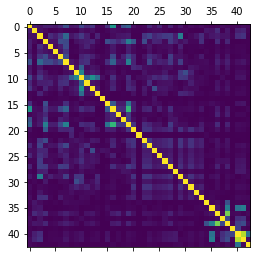

In [247]:
correlation = df.corr()
plt.matshow(abs(correlation))
plt.savefig('final_results/census/correlation_census.pdf')
plt.show()

In [248]:
correlation = abs(correlation)
correlation_ranking = correlation.mean().sort_values(ascending=False)
correlation_ranking.to_csv('final_results/census/correlation_ranking.csv')

In [249]:
df = df.sample(frac=1)

df_copy = df.copy()
df_positive_class = df_copy[(df_copy[census_bias] == 1)].copy()
df_negative_class = df_copy[(df_copy[census_bias] == 0)].copy()

rep_fraction = 0.12
bias_fraction = 0.05
negative_normal = len(df_negative_class)
positive_normal = len(df_positive_class)


#-----------------Simulate non-representative data---------------------#
rep = pd.concat([df_negative_class.head(int(negative_normal * 0.2)),
                df_positive_class.head(int(positive_normal * 0.2))],
                ignore_index=True) 

nonrep_more_negative_class = pd.concat([df_negative_class.tail(int(negative_normal * rep_fraction)), 
                             df_positive_class.tail(int(positive_normal * (rep_fraction - bias_fraction)))],
                            ignore_index=True)

nonrep_more_positive_class = pd.concat([df_negative_class.tail(int(negative_normal * (rep_fraction - bias_fraction))),
                             df_positive_class.tail(int(positive_normal * rep_fraction))], 
                             ignore_index=True)


#-----------------Simulate representative data---------------------#
rep2 = pd.concat([df_negative_class.tail(int(negative_normal * rep_fraction)),
                 df_positive_class.tail(int(positive_normal * rep_fraction))], 
                 ignore_index=True) 

rep['label'] = 0
nonrep_more_negative_class['label'] = 1
nonrep_more_positive_class['label'] = 1
rep2['label'] = 1

print("Current setting:")
print('Rep: \n', rep[census_bias].value_counts())
print('Rep 2: \n', rep2[census_bias].value_counts())
print('nonrep_more_positive_class: \n', nonrep_more_positive_class[census_bias].value_counts())
print('nonrep_more_negative_class: \n', nonrep_more_negative_class[census_bias].value_counts())

census_nonrep_more_negative_class = pd.concat([rep.copy(deep=True), nonrep_more_negative_class.copy(deep=True)])
census_nonrep_more_positive_class = pd.concat([rep.copy(deep=True), nonrep_more_positive_class.copy(deep=True)])
census_rep = pd.concat([rep.copy(deep=True), rep2.copy(deep=True)])

Current setting:
Rep: 
 0    3141
1    2891
Name: Marital Status_Married, dtype: int64
Rep 2: 
 0    1884
1    1734
Name: Marital Status_Married, dtype: int64
nonrep_more_positive_class: 
 1    1734
0    1099
Name: Marital Status_Married, dtype: int64
nonrep_more_negative_class: 
 0    1884
1    1011
Name: Marital Status_Married, dtype: int64


## Experiment 1 a)


### Simulate non-representative data. More married persons than in R

In [ ]:
drop = 25
number_of_splits = 5
test_size = 0.2
cv = 5
mmd_iteration = 1

representative_ratio = (len(rep[rep[census_bias] == 1]) 
                        / len(rep[rep[census_bias] == 0]))

ratio, auc_more_negativ, roc, mrs, mmds, mrs_iteration = repeated_MRS(census_nonrep_more_negative_class,
                    census_columns,
                    number_of_splits = number_of_splits, 
                    n_drop = drop,
                    test_size = test_size, cv = cv, us = True, 
                    census_bias=census_bias, 
                    mmd_iteration=mmd_iteration)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_more_negative_class", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_negative_class", 'wb'))
pickle.dump(auc_more_negativ, open("results/auc_more_negative_class", 'wb'))
pickle.dump(mmds, open("results/mmd_more_negative_class", 'wb'))
pickle.dump(mrs_iteration, open("results/more_negative_class_mrs_iterations", 'wb'))
pickle.dump(len(nonrep_more_negative_class), 
            open('results/len_of_more_negative_class', 'wb'))

### Load results

In [ ]:
ratio_more_negative_class = pickle.load(open("results/ratio_more_negative_class", 'rb'))
representative_ratio_more_negative_class = pickle.load(open(
    "results/representative_ratio_more_negative_class", 'rb'))
auc_more_negative = pickle.load(open("results/auc_more_negative_class", 'rb'))
mmd_more_negative_class = pickle.load(open("results/mmd_more_negative_class", 'rb'))
more_negative_class_mrs_iterations = pickle.load(open("results/more_negative_class_mrs_iterations", 'rb'))
len_of_more_negative_class = pickle.load(open('results/len_of_more_negative_class', 'rb'))

### Visualise results

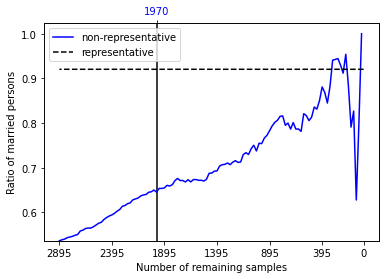

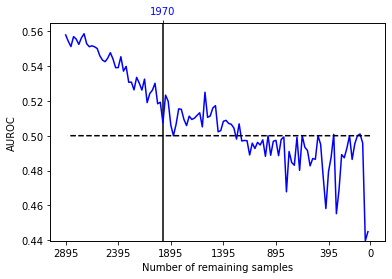

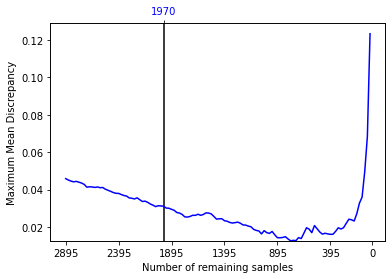

In [332]:
save = True
mmd_iteration = 1
drop = 25

file_directory = os.path.join(os.getcwd(), "final_results/census/more_negative/")
os.makedirs(file_directory, exist_ok=True)

plot_class_ratio(ratio_more_negative_class, representative_ratio_more_negative_class, 
                 file_directory+'ratio_more_negative',
                 more_negative_class_mrs_iterations, len_of_more_negative_class,
                 save=save)
plot_auc(auc_more_negative, drop, file_directory+'auc_more_negative', len_of_more_negative_class,
         save=save, 
         mrs_iterations=more_negative_class_mrs_iterations)
plot_mmds(mmd_more_negative_class, drop, mmd_iteration, file_directory+'mmd_more_negative', 
          more_negative_class_mrs_iterations, len_of_more_negative_class, save)

## Experiment 1 b)


### Simulate non-representative data. Less married persons than in R

In [ ]:
drop = 25
number_of_splits = 5
test_size = 0.2
mmd_iteration = 1
representative_ratio = (len(rep[rep[census_bias] == 1])
                        / len(rep[rep[census_bias] == 0]))
save = True
cv = 5

ratio, auc_more_positive_class, roc, mrs, mmds, mrs_iteration = repeated_MRS(census_nonrep_more_positive_class, census_columns,
                                                   number_of_splits = number_of_splits, n_drop = drop,
                                                   test_size = test_size, cv = cv, us = True, 
                                                   census_bias=census_bias, 
                                                   mmd_iteration=mmd_iteration)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_more_positive_class", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_positive_class", 'wb'))
pickle.dump(auc_more_positive_class, open("results/auc_more_positive_class", 'wb'))
pickle.dump(mmds, open("results/mmd_more_positive_class", 'wb'))
pickle.dump(mrs_iteration, open("results/more_positive_class_mrs_iterations", 'wb'))
pickle.dump(len(nonrep_more_positive_class), 
            open('results/len_of_more_positive_class', 'wb'))

### Load results

In [ ]:
ratio_more_positive = pickle.load(open("results/ratio_more_positive_class", 'rb'))
representative_ratio_more_positive = pickle.load(open("results/representative_ratio_more_positive_class", 'rb'))
auc_more_positive_class = pickle.load(open("results/auc_more_positive_class", 'rb'))
mmd_more_positive = pickle.load(open("results/mmd_more_positive_class", 'rb'))
more_positive_mrs_iterations = pickle.load(open("results/more_positive_class_mrs_iterations", 'rb'))
len_of_more_positive_class = pickle.load(open('results/len_of_more_positive_class', 'rb'))

### Visualise results

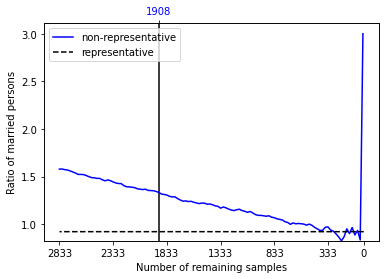

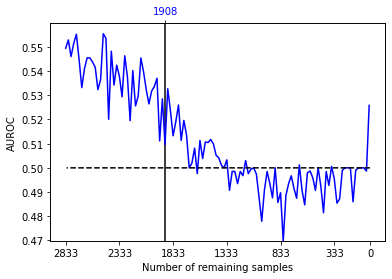

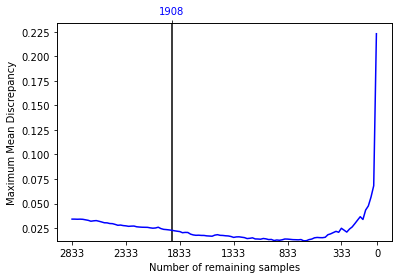

In [333]:
save = True
mmd_iteration = 1

drop = 25
file_directory = os.path.join(os.getcwd(), "final_results/census/more_positive/")
os.makedirs(file_directory, exist_ok=True)

plot_class_ratio(ratio_more_positive, representative_ratio_more_positive,
                 file_directory+'ratio_more_positive', more_positive_mrs_iterations, 
                 len_of_more_positive_class, save=save)
plot_auc(auc_more_positive_class, drop, file_directory+'auc_more_positive', len_of_more_positive_class, 
         save=save,
         mrs_iterations=more_positive_mrs_iterations)
plot_mmds(mmd_more_positive, drop, mmd_iteration, file_directory+'mmd_more_positive', 
          more_positive_mrs_iterations, len_of_more_positive_class, save)

## Experiment 1 c)


### Simulate already representative data

In [ ]:
drop = 25
number_of_splits = 5
test_size = 0.2
representative_ratio = (len(rep[rep[census_bias] == 1]) / len(rep[rep[census_bias] == 0]))
cv = 3
mmd_iteration = 1
save = True

ratio, auc_same, roc, new_same, mmds, mrs_iteration = repeated_MRS(census_rep, census_columns,
                                            number_of_splits = number_of_splits, n_drop = drop,
                                            test_size = test_size, cv = cv, us = True, 
                                            census_bias=census_bias, 
                                            mmd_iteration=mmd_iteration)

### Save results

In [ ]:
pickle.dump(ratio, open("results/ratio_same", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_same", 'wb'))
pickle.dump(auc_same, open("results/auc_same", 'wb'))
pickle.dump(mmds, open("results/mmd_same", 'wb'))
pickle.dump(mrs_iteration, open("results/same_mrs_iterations", 'wb'))
pickle.dump(len(rep2), open('results/len_of_rep', 'wb'))

### Load results

In [ ]:
ratio_same = pickle.load(open("results/ratio_same", 'rb'))
representative_ratio_same = pickle.load(open("results/representative_ratio_same", 'rb'))
auc_same = pickle.load(open("results/auc_same", 'rb'))
mmd_same = pickle.load(open("results/mmd_same", 'rb'))
same_mrs_iterations = pickle.load(open("results/same_mrs_iterations", 'rb'))
len_of_rep = pickle.load(open('results/len_of_rep', 'rb'))

### Visualise results

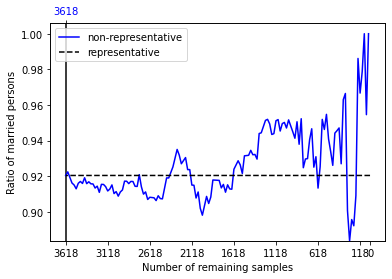

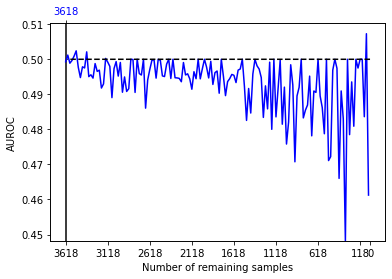

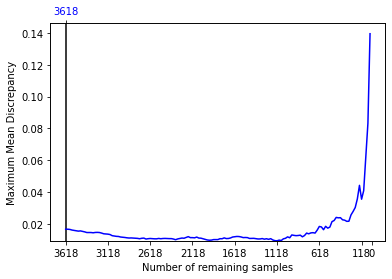

In [334]:
save = True
mmd_iteration = 1
same_drop = 25
file_directory = os.path.join(os.getcwd(), "final_results/census/same/")
os.makedirs(file_directory, exist_ok=True)

plot_class_ratio(ratio_same, representative_ratio_same, file_directory+'ratio_same', 
                 same_mrs_iterations, len_of_rep, save=save)
plot_auc(auc_same, same_drop, file_directory+'auc_same', len_of_rep, 
         save=save, mrs_iterations=same_mrs_iterations)
plot_mmds(mmd_same, same_drop, mmd_iteration,
          file_directory+'mmd_same', same_mrs_iterations, len_of_rep, save)

## Experiment 2
### <font color='darkgreen'>Allensbach</font>   <---MRS---> <font color='darkred'>GBS</font> <---MRS---> <font color='darkgreen'>GESIS</font> 

*Figure shows MRS concept on GBS and GESIS for experiment 2 a). Replace Allensbach with GESIS for experiment 2 b)*

<img src="overview.PNG" width="450" height="450"/>


**Multivariate auxiliary information GESIS linked to GBS so that expected selection bias can be detected and corrected for. 


## Experiment 2 a)
### <font color='darkgreen'>Allensbach Studie - Institut für Demoskopie(IfD)</font>  <a name="us"></a>

### <font color='darkred'>Important note:</font>  <a name="allensbach"></a> Allensbach is already merged with GBS in this data set


In [ ]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'Berufsgruppe', 'Erwerbstaetigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit', 'Resilienz']

allensbach_scaler = StandardScaler()
scaled_allensbach = allensbach.copy(deep=True)
scaled_allensbach[allensbach_columns] = allensbach_scaler.fit_transform(scaled_allensbach[allensbach_columns])

In [ ]:
drop = 5
number_of_splits = 5
repetetions = 10
cv = 5

test_size = 0.3
number_of_iterations = int(len(scaled_allensbach[scaled_allensbach['label']  == 1]) / drop)

aucs = []
rocs = []
mmds = []
mmd_iteration = 1
mrs_iterations = []

for _ in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_allensbach, allensbach_columns,
                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=cv)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)  

### Save results

In [ ]:
pickle.dump(median_aucs, open("results/allensbach_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allensbach_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/allensbach_median_rocs", 'wb'))

pickle.dump(median_mmds, open("results/allensbach_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/allensbach_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/allensbach_mrs_iterations", 'wb'))
pickle.dump(drop, open("results/allensbach_drop", "wb"))
pickle.dump(mmd_iteration, (open("results/allensbach_mmd_iteration", 'wb')))
pickle.dump(len(scaled_allensbach[scaled_allensbach['label']  == 1]),
          (open("results/allensbach_len", 'wb')))  

### Load  results

In [48]:
allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))
allensbach_rocs = pickle.load(open("results/allensbach_median_rocs", "rb"))
allensbach_mrs_iterations =  pickle.load(open("results/allensbach_mrs_iterations", 'rb'))
allensbach_median_mmds =  pickle.load(open("results/allensbach_median_mmds", 'rb'))
allensbach_std_mmds =  pickle.load(open("results/allensbach_std_mmds", 'rb'))
allensbach_drop = pickle.load(open("results/allensbach_drop", 'rb'))
allensbach_mmd_iteration = pickle.load(open("results/allensbach_mmd_iteration", 'rb'))
allensbach_len = pickle.load(open("results/allensbach_len", 'rb'))  

### Visualise results

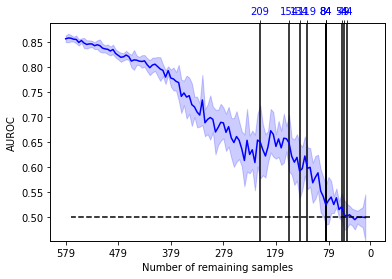

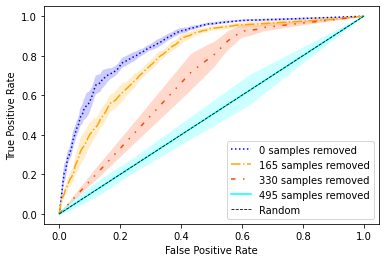

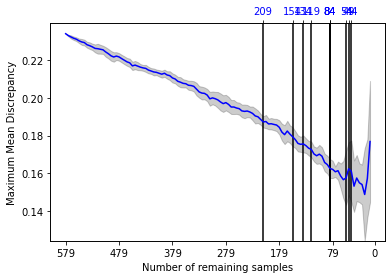

In [335]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/allensbach/")
os.makedirs(file_directory, exist_ok=True)
mmd_iteration = 1

plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, allensbach_drop, 
                file_directory+"allensbach_auc_with_iterations", allensbach_len, save=save, 
                mrs_iterations=allensbach_mrs_iterations)
plot_rocs(allensbach_rocs, file_directory+"allensbach_rocs", save=save)
plot_mmds_median(allensbach_median_mmds, allensbach_std_mmds, allensbach_drop, allensbach_mmd_iteration, 
                 file_directory + "median_mmds_allensbach",
                 allensbach_mrs_iterations, allensbach_len, save=save)

### Experiment 2 b)


### <font color='darkgreen'>Load Gesis</font>  <a name="us"></a>

In [ ]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Berufsgruppe', 'Wahlteilnahme', 'BRS6']

N = gbs.copy()
R = gesis.copy()

N['label'] = 1
R['label'] = 0

gesis_gbs = pd.concat([N, R], ignore_index=True)

In [ ]:
gesis_scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_columns] = gesis_scaler.fit_transform(scaled_gesis_gbs[gesis_columns])

In [ ]:
drop = 5
number_of_splits = 5
cv = 5

test_size = 0.3
repetetions = 10
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop) 

aucs = []
rocs = []
mmds = []
mmd_iteration = 1
mrs_iterations = []

for _ in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns, 
                                                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=cv,
                                             number_of_iterations=number_of_iterations)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs)
    median_mmds = np.median(mmds, axis = 0)
    std_mmds = np.std(mmds, axis = 0)
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis=0)

### Save results

In [ ]:
pickle.dump(median_aucs, open("results/gesis_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/gesis_median_rocs", 'wb'))
pickle.dump(median_mmds, open("results/gesis_median_mmds", 'wb'))
pickle.dump(std_mmds, open("results/gesis_std_mmds", 'wb'))
pickle.dump(mrs_iterations, open("results/gesis_mrs_iterations", 'wb'))
pickle.dump(drop, open("results/gesis_drop", "wb"))
pickle.dump(mmd_iteration, open("results/gesis_mmd_iteration", 'wb'))
pickle.dump(len(gbs), open('results/len_gbs', 'wb'))

### Load results

In [73]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_rocs =  pickle.load(open("results/gesis_median_rocs", 'rb'))
gesis_mrs_iterations =  pickle.load(open("results/gesis_mrs_iterations", 'rb'))
gesis_median_mmds =  pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds =  pickle.load(open("results/gesis_std_mmds", 'rb'))
gesis_drop = pickle.load(open("results/gesis_drop", 'rb'))
gesis_mmd_iteration = pickle.load(open("results/gesis_mmd_iteration", 'rb'))
len_gbs = pickle.load(open('results/len_gbs', 'rb'))

### Visualise results

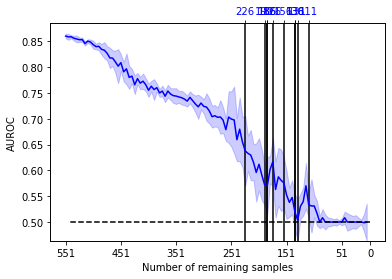

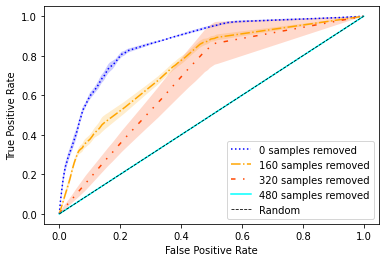

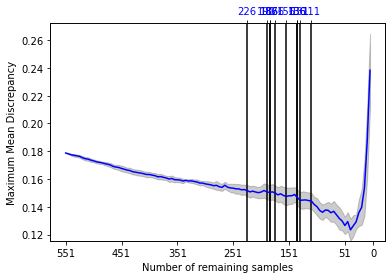

In [336]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/gesis/")
os.makedirs(file_directory, exist_ok=True)

plot_auc_median(gesis_median_aucs, gesis_std_aucs, gesis_drop, 
                file_directory+"gesis_auc_with_iterations", len_gbs, save=save, 
                mrs_iterations=gesis_mrs_iterations)
plot_rocs(gesis_median_rocs, file_directory+"gesis_rocs", save=save)
plot_mmds_median(gesis_median_mmds, gesis_std_mmds, gesis_drop, gesis_mmd_iteration, 
                 file_directory + "median_mmds_gesis", gesis_mrs_iterations, len_gbs, save=save)

# Compare MRS with temperature sampling and sampling 

### Run experiment

In [ ]:
drop = 5
number_of_splits = 5

cv= 5
test_size = 0.3
repetetions = 10
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1]) / drop)
aucs_without_temperature = []
rocs_without_temperature = []
mmds_without_temperature = []
mrs_iterations = []
mmd_iteration = 1
    
for _ in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS(scaled_gesis_gbs, gesis_columns,
                     number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv,
                                                 number_of_iterations=number_of_iterations, 
                                                     temperature_sampling=False)
    
    aucs_without_temperature.append(auc)
    rocs_without_temperature.append(roc)
    mmds_without_temperature.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_temperature)
    median_mmds = np.median(mmds_without_temperature, axis = 0)
    std_mmds = np.std(mmds_without_temperature, axis = 0)
    median_aucs = np.median(aucs_without_temperature, axis = 0)
    std_aucs = np.std(aucs_without_temperature, axis = 0)

### Save results

In [ ]:
pickle.dump(median_aucs, open("results/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs, open("results/std_aucs_without_temperature", 'wb'))
pickle.dump(median_rocs, open("results/median_rocs_without_temperature", 'wb'))
pickle.dump(median_mmds, open("results/median_mmds_without_temperature", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_temperature", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_temperature", 'wb'))
pickle.dump(drop, open("results/drop_without_temperature", 'wb'))
pickle.dump(mmd_iteration, open("results/mmd_iteration_without_temperature", 'wb'))

### Load saved results

In [10]:
median_aucs_without_temperature = pickle.load(open("results/median_aucs_without_temperature", 'rb'))
std_aucs_without_temperature = pickle.load(open("results/std_aucs_without_temperature", 'rb'))
median_aucs_temperature = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_temperature = pickle.load(open("results/gesis_std_aucs", 'rb'))

median_mmds_without_temperature = pickle.load(open("results/median_mmds_without_temperature", 'rb'))
std_mmds_without_temperature = pickle.load(open("results/std_mmds_without_temperature", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_temperature = pickle.load(open("results/mrs_iterations_without_temperature", 'rb'))
drop_without_temperature = pickle.load(open("results/drop_without_temperature", 'rb'))
mmd_iteration_without_temperature = pickle.load(open("results/mmd_iteration_without_temperature", 'rb'))
len_gbs = pickle.load(open('results/len_gbs', 'rb'))

### Visualise results

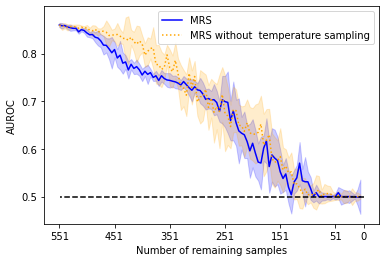

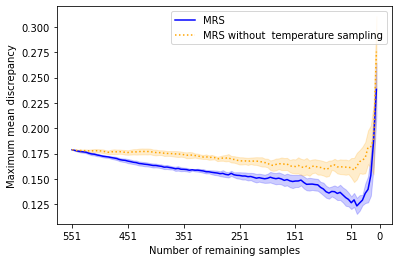

In [11]:
experiment_label = 'MRS without  temperature sampling'   
file_directory = os.path.join(os.getcwd(), "final_results/temperature_comparison/")
os.makedirs(file_directory, exist_ok=True)
save = True

plot_experiment_comparison_auc(median_aucs_temperature, std_aucs_temperature, median_aucs_without_temperature, 
                                std_aucs_without_temperature, experiment_label, 
                           drop_without_temperature, file_directory + 'aucs_temperature', len_gbs, 
                               save=save)   
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_temperature, 
                               std_mmds_without_temperature, 
                               experiment_label, drop_without_temperature, mmd_iteration_without_temperature, 
                               file_directory + 'mmds_temperature', len_gbs, save=save)

# Compare MRS with cross-validation and without

In [ ]:
def MRS_without_cv(N: pd.DataFrame, R: pd.DataFrame, columns: list, number_of_splits = 5,
        n_drop: int=1, cv=5):
    EPSILON = 10e-16 # to avoid dividing by zero
    preds = []
    bootstrap_iterations = 25
    kf = KFold(n_splits=number_of_splits)
    bootstrap_predictions_n = np.zeros(len(N))
    bootstrap_predictions_r = np.zeros(len(R))
    counter_n = np.zeros(len(N))
    counter_r = np.zeros(len(R))
    
    n = min(len(R), len(N))
    for _ in range(bootstrap_iterations):
        n_sample = N.sample(n=n, replace=True)
        N_test = N.drop(n_sample.index)
        r_sample = R.sample(n=n, replace=True)
        R_test = R.drop(r_sample.index)
        locations_not_in_bootstrap_n = list(set([N.index.get_loc(index) for index in N_test.index]))
        locations_not_in_bootstrap_r = list(set([R.index.get_loc(index) for index in R_test.index]))
        
        bootstrap = pd.concat([n_sample, r_sample])
        clf = grid_search(bootstrap[columns], bootstrap.label, 5)
        proba_n = clf.predict_proba(N_test[columns])[:,1]
        proba_r = clf.predict_proba(R_test[columns])[:,1]
        bootstrap_single_n = np.zeros(len(N))
        bootstrap_single_n[list(locations_not_in_bootstrap_n)] = proba_n
        counter_n[list(locations_not_in_bootstrap_n)] += 1
        bootstrap_predictions_n += bootstrap_single_n
        
        bootstrap_single_r = np.zeros(len(R))
        bootstrap_single_r[list(locations_not_in_bootstrap_r)] = proba_r
        counter_r[list(locations_not_in_bootstrap_r)] += 1
        bootstrap_predictions_r += bootstrap_single_r
        
    counter_n = [EPSILON if x == 0 else x for x in counter_n]
    counter_r = [EPSILON if x == 0 else x for x in counter_r]
    preds_n = bootstrap_predictions_n / counter_n
    preds_r = bootstrap_predictions_r / counter_r
    
    all_preds = np.concatenate([preds_n, preds_r])
    all_true = np.concatenate([np.ones(len(preds_n)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    mapped_auc = abs(auc - 0.5)
    temperature = -0.55 * mapped_auc + 0.3
    drop_ids = temperature_sample(preds_n, temperature, n_drop)
    return N.drop(N.index[drop_ids])

In [ ]:
def repeated_MRS_without_cv(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, 
                 census_bias='', temperature_sampling=True, number_of_iterations=None):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    if number_of_iterations is None:
        number_of_iterations = int(len(N) / drop)
    aucs = []
    rocs = []
    ratio = []
    mmds = []
    kl_values = []
    mmd_iteration = 1
    
    auroc_iteration = int(int(len(N) / n_drop) / 3.5) + 1
    
    if us:
        representative_ratio = (len(R[R[census_bias] == 1]) /
                                len(R[R[census_bias] == 0]))
        ratio.extend([len(N[N[census_bias] == 1]) / 
                         (len(N[N[census_bias] == 0]))]*drop)
        
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    rocs.append(roc)
    mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    mrs = N
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS_without_cv(N, R, columns,
                                number_of_splits=number_of_splits,
                                n_drop=n_drop, cv=cv)
        
        if((i+1) % auroc_iteration == 0):
            auc, roc = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=True)
            aucs.append(auc)
            rocs.append(roc)
        else:
            auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
            aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * n_drop
            mrs = N.copy(deep=True)
            
        
        if ((i+1) % mmd_iteration == 0):
            mmds.append(maximum_mean_discrepancy(N[columns], R[columns]))
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    
    return aucs, rocs, mrs, mmds, mrs_iteration 

In [ ]:
drop = 5
number_of_splits = 5

test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) / drop)
repetetions = 10
cv = 5
aucs_without_cv = [] 
aucs_without_cv = []
rocs_without_cv = []
mmds_without_cv = []
mrs_iterations = []
mmd_iteration = 1
save=False
    
for temp in tqdm(range(repetetions)):
    auc, roc, mrs, mmd, mrs_iteration = repeated_MRS_without_cv(scaled_gesis_gbs, gesis_columns, 
                    number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, number_of_iterations=number_of_iterations)
    
    aucs_without_cv.append(auc)
    rocs_without_cv.append(roc)
    mmds_without_cv.append(mmd)
    mrs_iterations.append(mrs_iteration)
    
    median_rocs = calculate_median_rocs(rocs_without_cv)
    median_mmds = np.median(mmds_without_cv, axis = 0)
    std_mmds = np.std(mmds_without_cv, axis = 0)
    median_aucs = np.median(aucs_without_cv, axis = 0)
    std_aucs = np.std(aucs_without_cv, axis = 0)

### Save results

In [101]:
pickle.dump(median_aucs, open("results/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs, open("results/std_aucs_without_cv", 'wb'))
pickle.dump(median_mmds, open("results/median_mmds_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))

pickle.dump(median_rocs, open("results/median_rocs_without_cv", 'wb'))
pickle.dump(std_mmds, open("results/std_mmds_without_cv", 'wb'))
pickle.dump(mrs_iterations, open("results/mrs_iterations_without_cv", 'wb'))

pickle.dump(drop, open("results/drop_without_cv", 'wb'))
pickle.dump(mmd_iteration, open("results/mmd_iteration_without_cv", 'wb'))

NameError: name 'median_aucs' is not defined

### Load results

In [12]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
median_aucs_without_cv = pickle.load(open("results/median_aucs_without_cv", 'rb'))
std_aucs_without_cv = pickle.load(open("results/std_aucs_without_cv", 'rb'))

median_mmds_without_cv = pickle.load(open("results/median_mmds_without_cv", 'rb'))
std_mmds_without_cv = pickle.load(open("results/std_mmds_without_cv", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))

mrs_iterations_without_cv = pickle.load(open("results/mrs_iterations_without_cv", 'rb'))
drop_without_cv = pickle.load(open("results/drop_without_temperature", 'rb'))
mmd_iteration_without_cv = pickle.load(open("results/mmd_iteration_without_temperature", 'rb'))
len_gbs = pickle.load(open('results/len_gbs', 'rb'))

### Visualise results

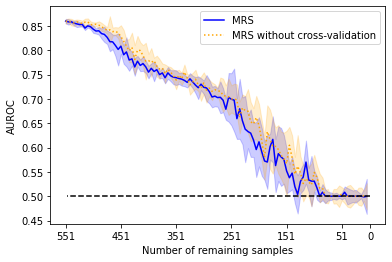

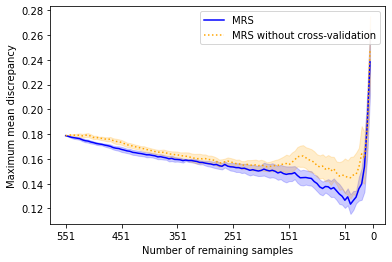

In [13]:
save = True
file_directory = os.path.join(os.getcwd(), "final_results/cross_validation_comparison/")
os.makedirs(file_directory, exist_ok=True)

experiment_label = 'MRS without cross-validation'


 
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs, median_aucs_without_cv, 
                                std_aucs_without_cv, experiment_label, drop_without_cv, 
                           file_directory+'auc_cv', len_gbs, save=save)    
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_without_cv, 
                               std_mmds_without_cv, 
                               experiment_label, drop_without_cv, mmd_iteration_without_cv, 
                               file_directory+'mmd_cv', len_gbs, save=save)

# Random drops

### Run experiment

In [ ]:
drop = 5
cv = 5
test_size = 0.3
repetetions = 10
number_of_splits = 5
aucs_random_drop = []
mmds = []
mrs_iterations = []
mmd_iteration = 1

data = scaled_gesis_gbs
columns = gesis_columns
iterations = int(len(data[data['label'] == 1]) / drop) 

for _ in tqdm(range(repetetions)): 
    N = data[data['label'] == 1].copy()
    R = data[data['label'] == 0].copy()
    aucs = [] 
    mmd = []
    
    #start value
    auc, roc = auc_prediction(N, R, columns, test_size, drop, 0, cv, True)
    aucs.append(auc)
    mmd.append(maximum_mean_discrepancy(N[columns], R[columns]))
    
    best_auc = auc
    mrs_iteration = 0
    min_delta = 0.005
    
    for i in tqdm(range(iterations)):
        drop_ids = random.sample(range(0, len(N)), drop)
        N.drop(N.index[drop_ids], inplace=True)

        auc, _ = auc_prediction(N, R, columns, test_size, drop, i+1, cv, calculate_roc=False)
        aucs.append(auc)
        
        if abs(auc - 0.5) < abs(best_auc - 0.5) - min_delta:
            best_auc = auc
            mrs_iteration = (i + 1) * drop
            
        if ((i+1) % mmd_iteration == 0):
            mmd.append(maximum_mean_discrepancy(N[columns], R[columns]))
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
        
    mrs_iterations.append(mrs_iteration)
    aucs_random_drop.append(aucs)
    mmds.append(mmd)
    median_aucs_random_drop = np.median(aucs_random_drop, axis = 0)
    median_mmd_random_drop = np.median(mmds, axis = 0)
    std_aucs_random_drop = np.std(aucs_random_drop, axis = 0)
    std_mmds_random_drop = np.std(mmds, axis = 0)

### Save results

In [ ]:
pickle.dump(median_aucs_random_drop, open("results/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open("results/std_aucs_random_drop", 'wb'))
pickle.dump(median_mmd_random_drop, open("results/median_mmds_random_drop", 'wb'))
pickle.dump(std_mmds_random_drop, open("results/std_mmds_random_drop", 'wb'))
pickle.dump(drop, open("results/random_drop_drop", "wb"))
pickle.dump(mmd_iteration, open("results/random_drop_mmd_iteration", "wb"))

### Load saved results

In [14]:
median_aucs_random_drop = pickle.load(open("results/median_aucs_random_drop", 'rb'))
std_aucs_random_drop = pickle.load(open("results/std_aucs_random_drop", 'rb'))
median_mmds_random_drop = pickle.load(open("results/median_mmds_random_drop", 'rb'))
std_mmds_random_drop = pickle.load(open("results/std_mmds_random_drop", 'rb'))
random_drop_drop = pickle.load(open("results/random_drop_drop", 'rb'))

gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_mmds = pickle.load(open("results/gesis_median_mmds", 'rb'))
gesis_std_mmds = pickle.load(open("results/gesis_std_mmds", 'rb'))
random_drop_mmd_iteration = pickle.load(open("results/random_drop_mmd_iteration", "rb"))
len_gbs = pickle.load(open('results/len_gbs', 'rb'))

### Visualise results

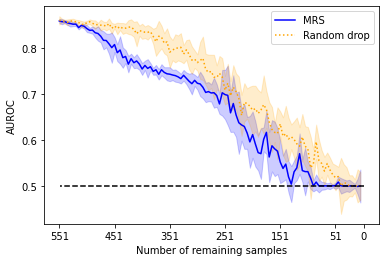

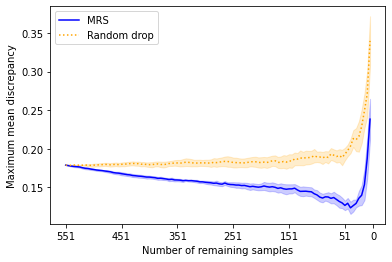

In [15]:
file_directory = os.path.join(os.getcwd(), "final_results/random/")
os.makedirs(file_directory, exist_ok=True)
save = True
random_drop_drop = 5
experiment_label = 'Random drop'
plot_experiment_comparison_auc(gesis_median_aucs, gesis_std_aucs,
                               median_aucs_random_drop, std_aucs_random_drop, 
                               experiment_label, random_drop_drop, file_directory+'aucs_random', len_gbs,
                               save)
plot_experiment_comparison_mmd(gesis_median_mmds, gesis_std_mmds,  median_mmds_random_drop, 
                               std_mmds_random_drop, 
                               experiment_label, random_drop_drop, random_drop_mmd_iteration,
                               file_directory+'mmd_random', len_gbs,
                               save=save)

## Correlation between resilience and voting

  0%|          | 0/5 [00:00<?, ?it/s]

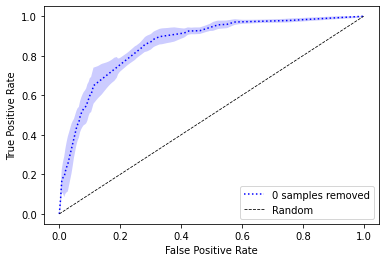

  0%|          | 0/115 [00:00<?, ?it/s]

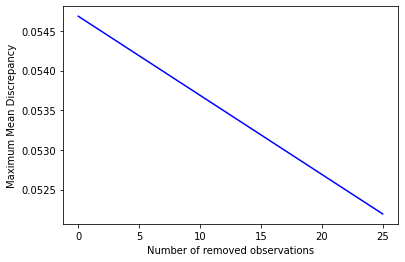

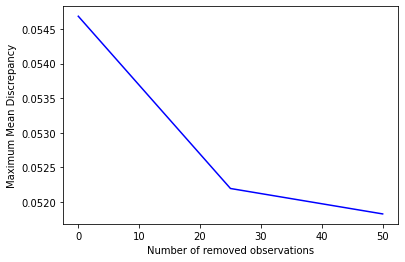

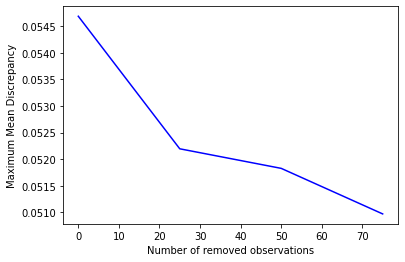

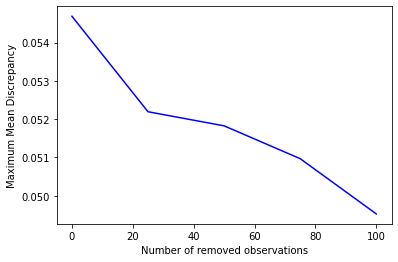

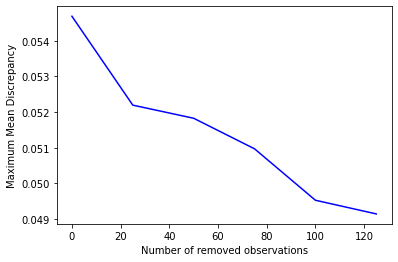

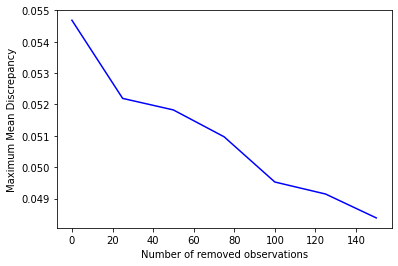

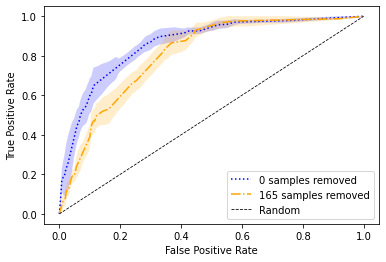

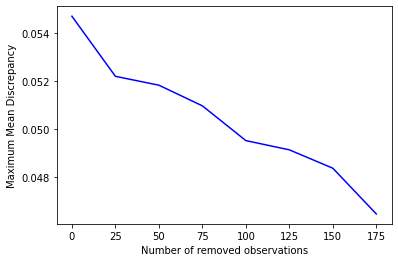

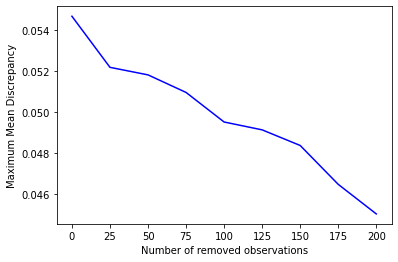

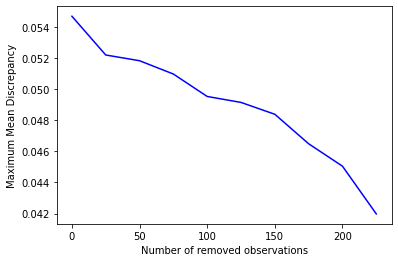

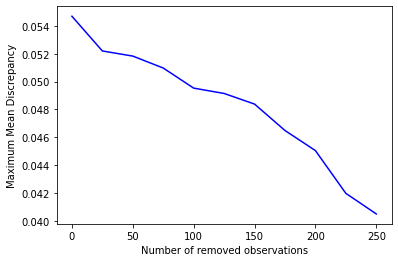

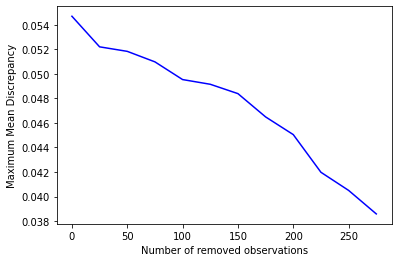

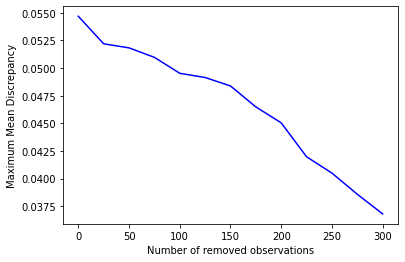

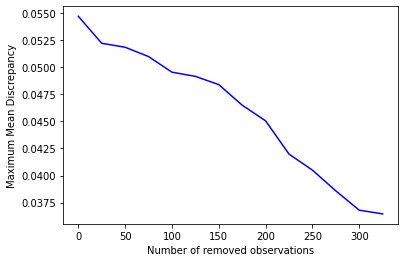

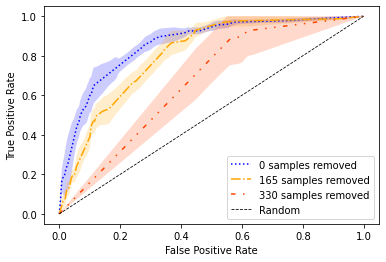

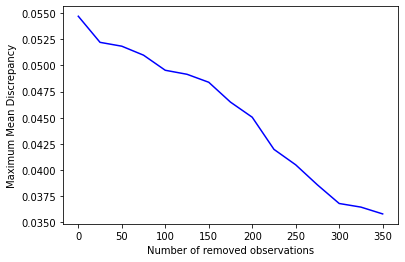

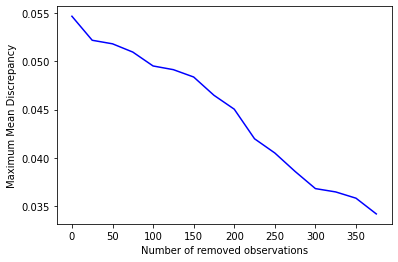

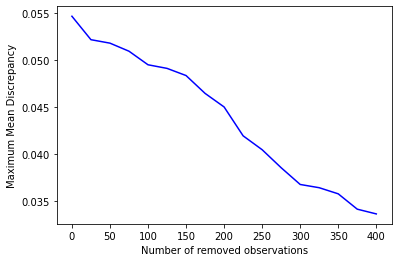

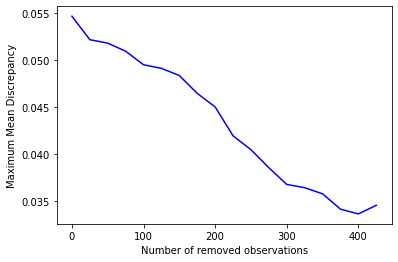

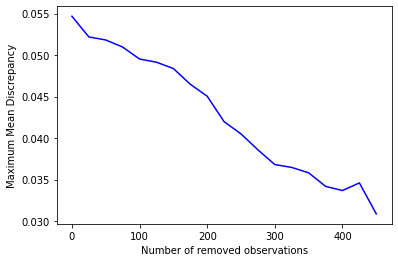

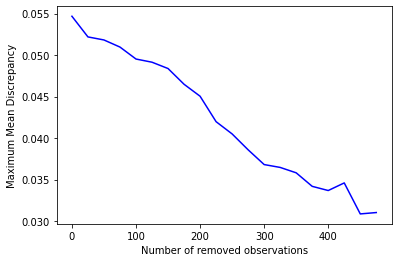

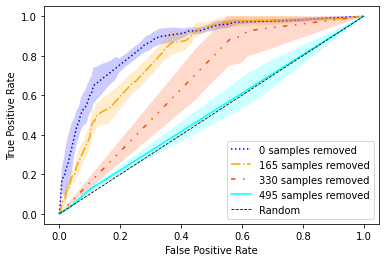

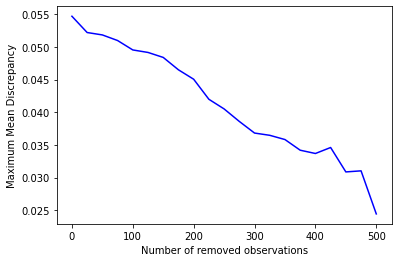

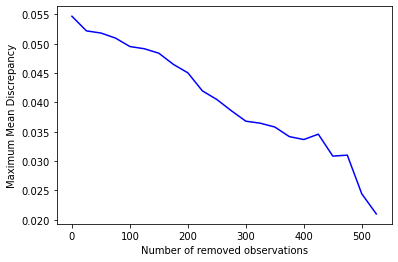

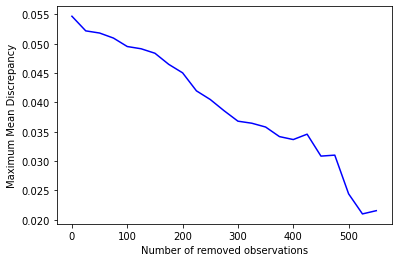

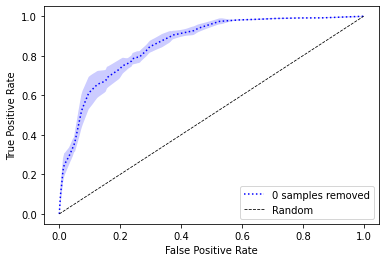

  0%|          | 0/115 [00:00<?, ?it/s]

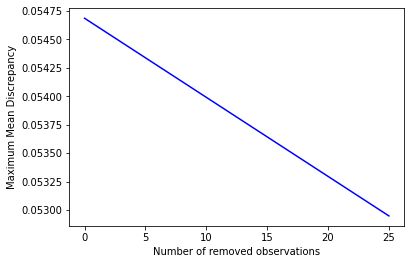

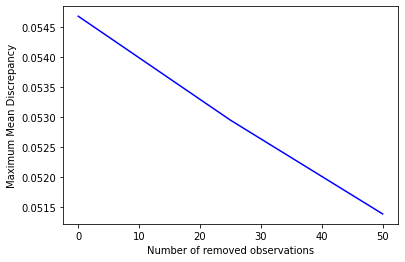

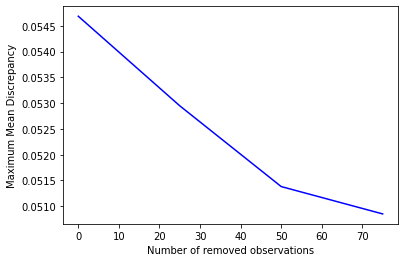

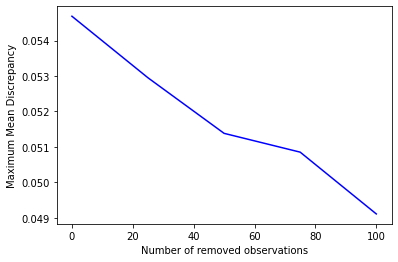

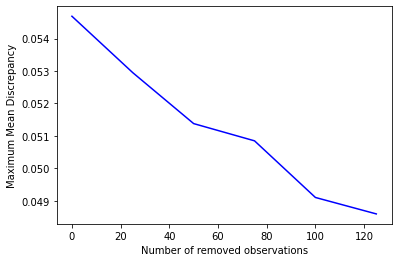

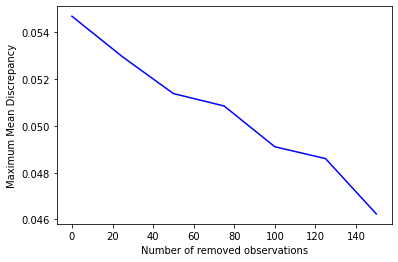

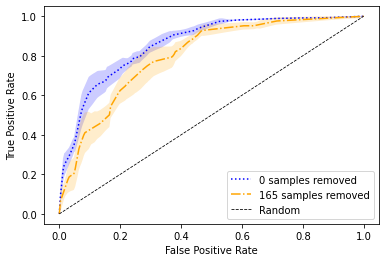

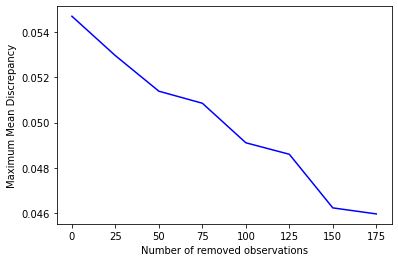

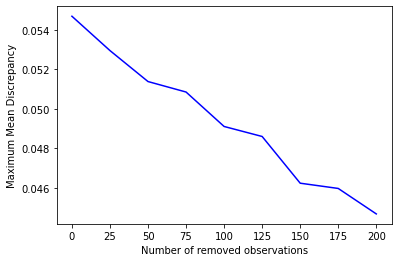

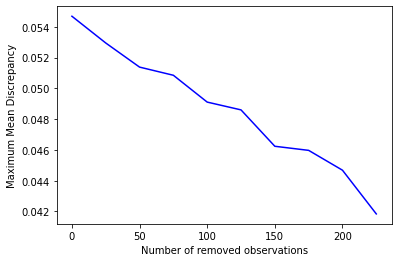

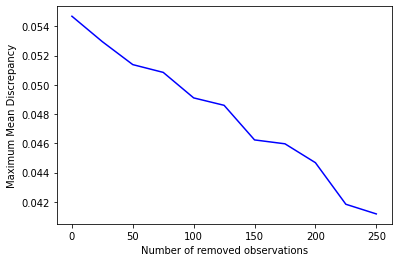

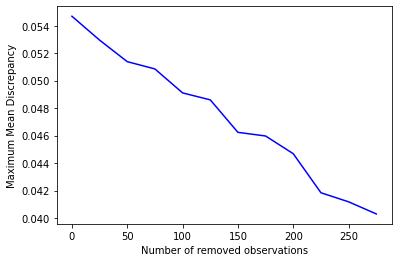

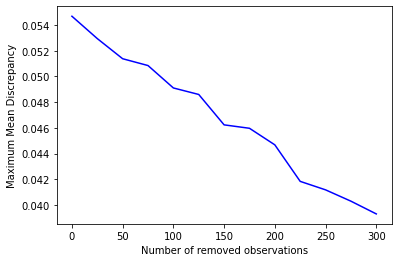

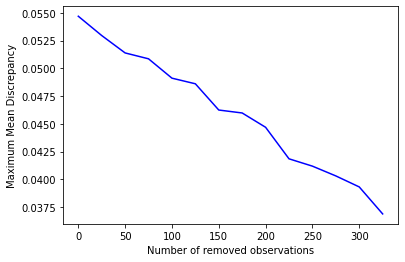

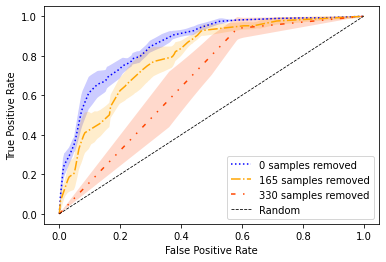

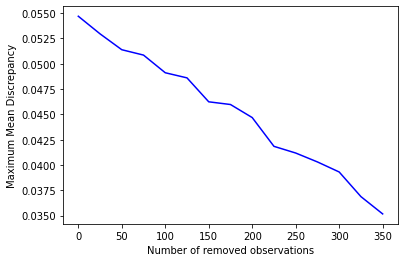

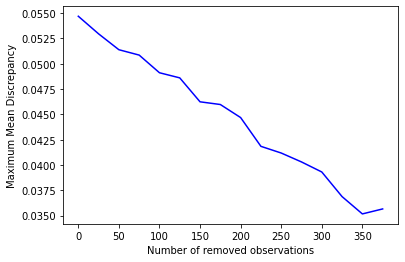

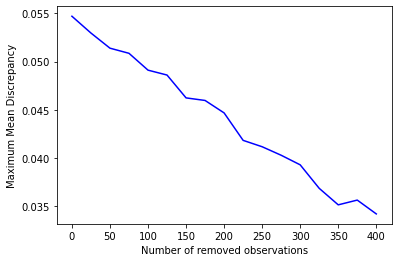

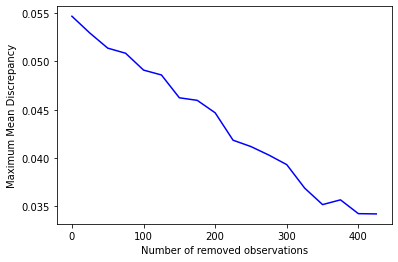

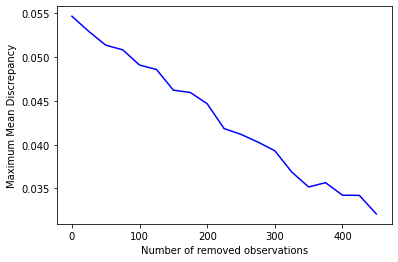

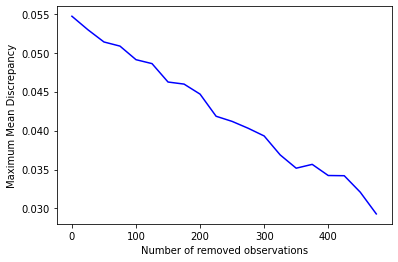

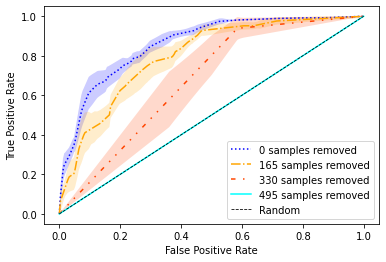

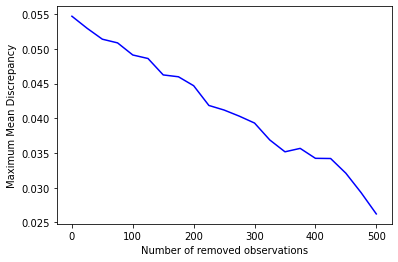

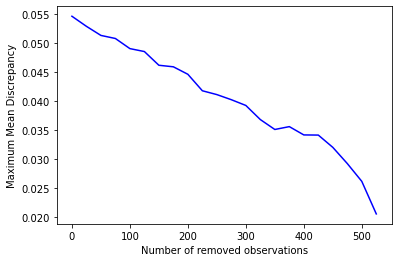

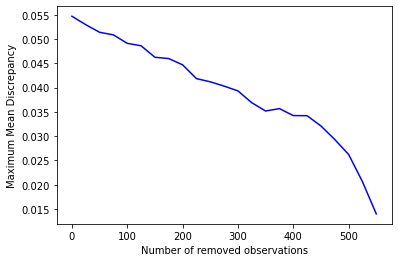

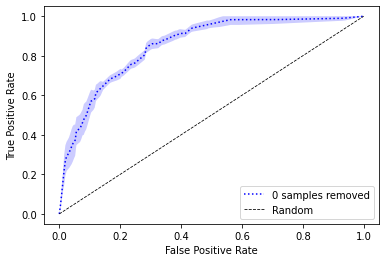

  0%|          | 0/115 [00:00<?, ?it/s]

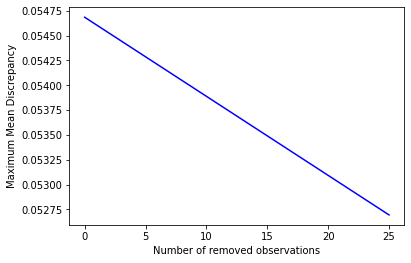

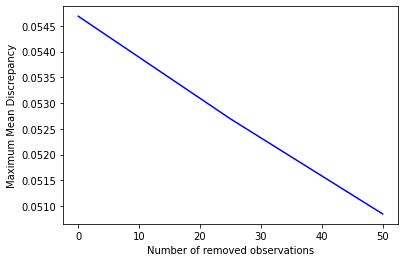

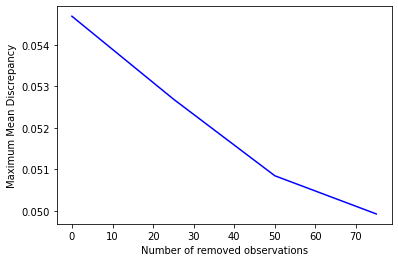

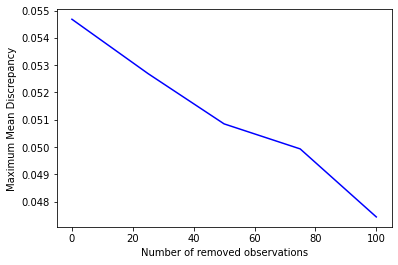

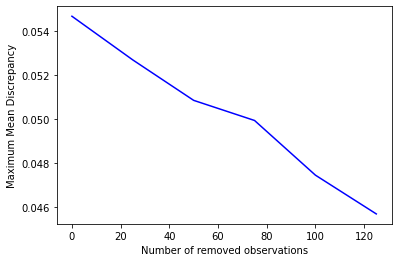

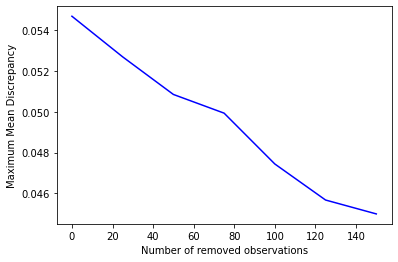

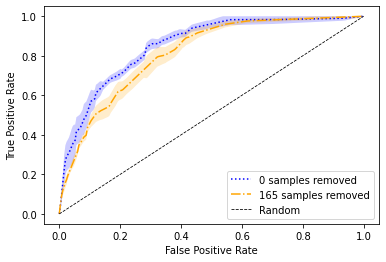

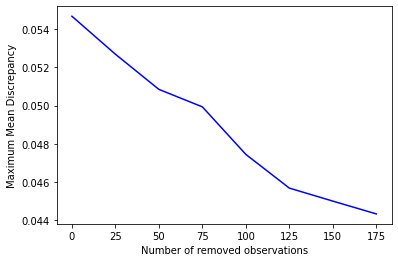

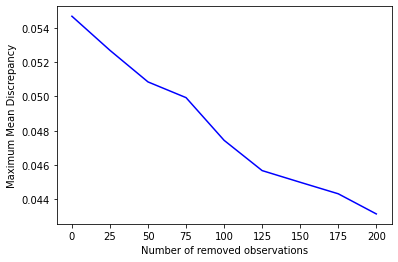

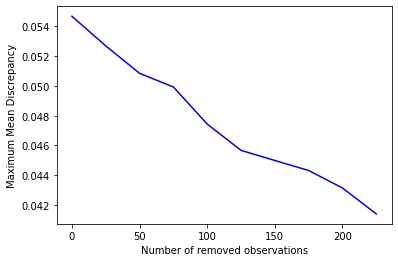

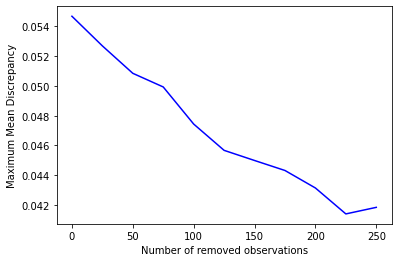

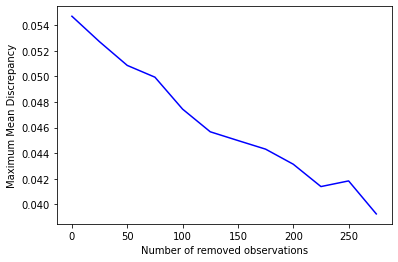

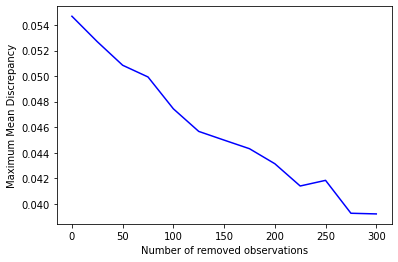

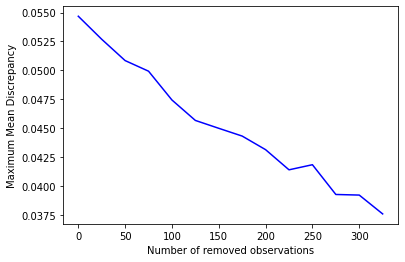

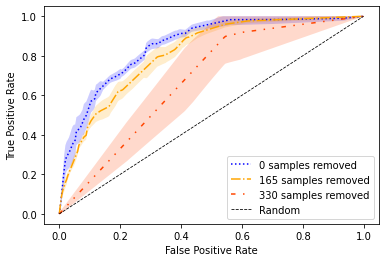

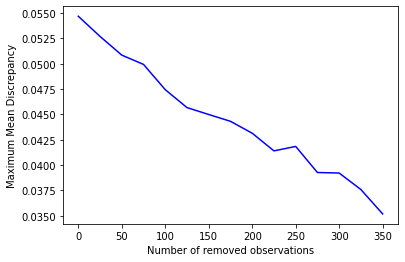

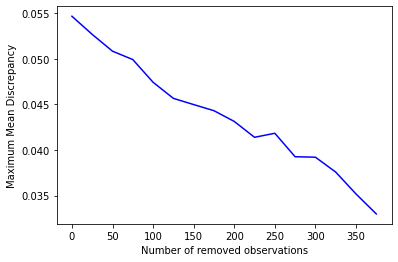

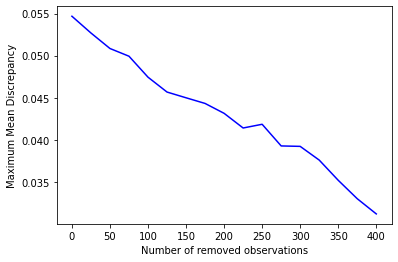

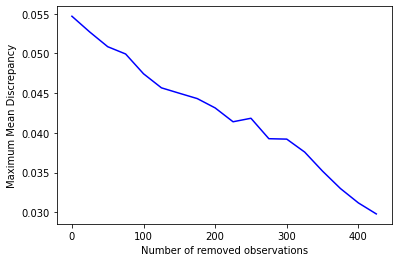

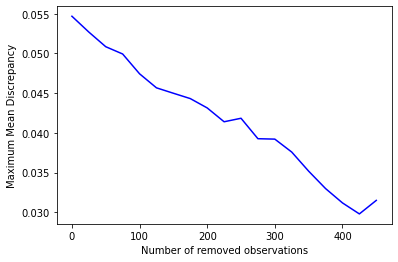

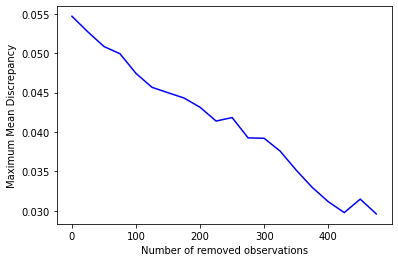

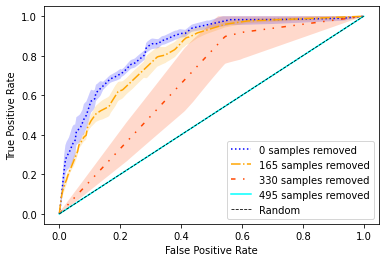

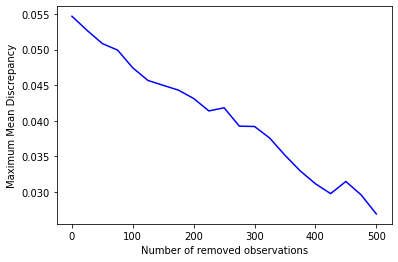

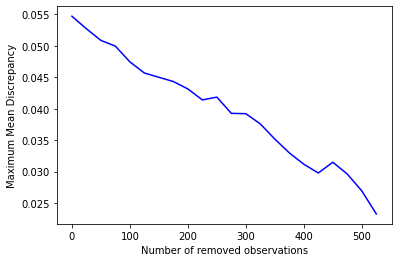

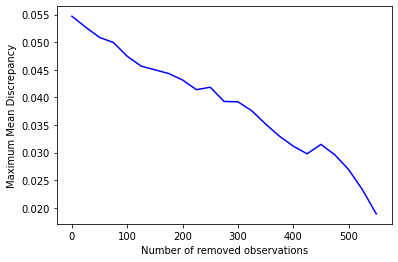

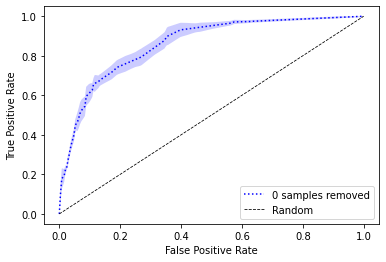

  0%|          | 0/115 [00:00<?, ?it/s]

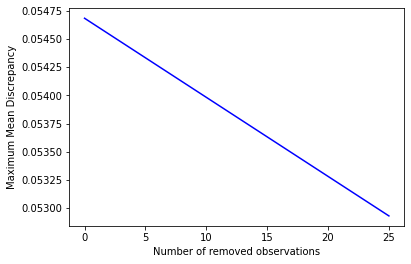

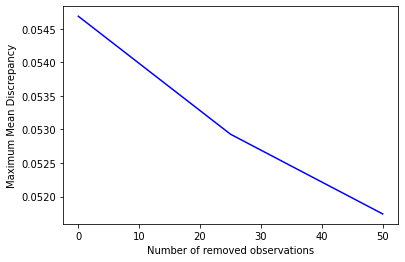

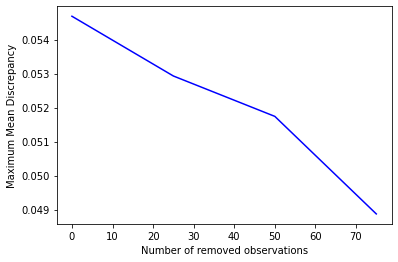

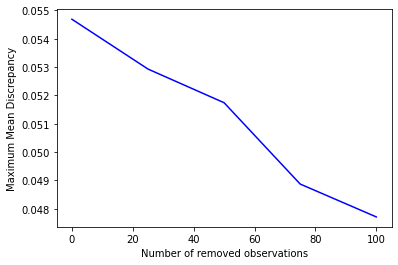

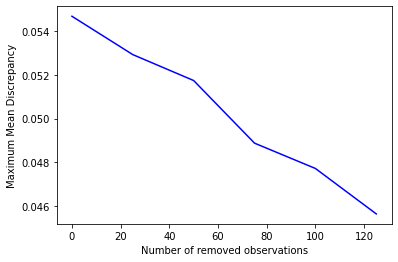

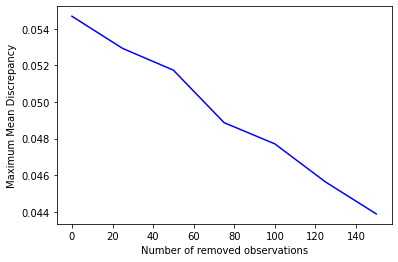

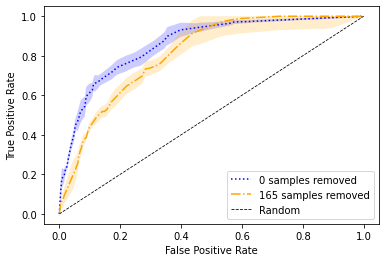

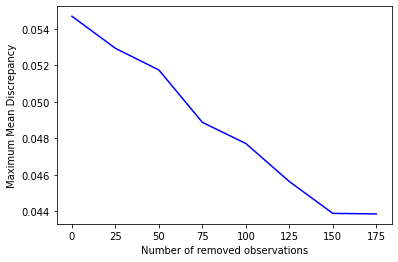

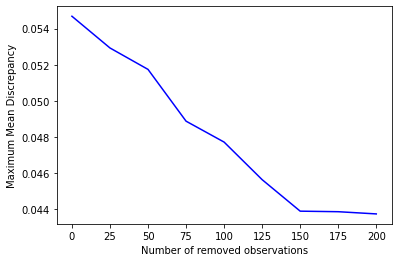

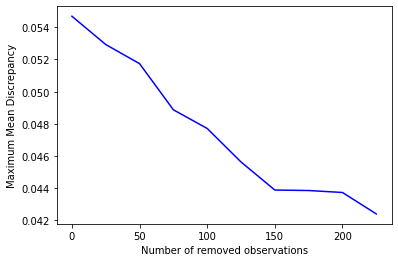

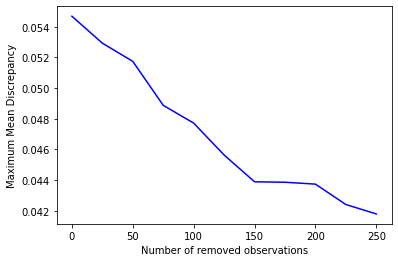

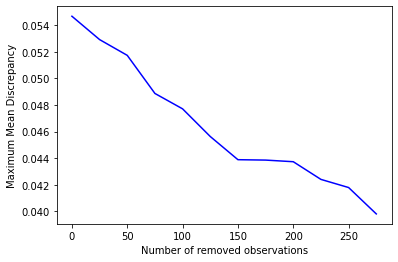

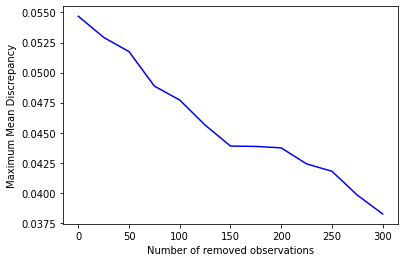

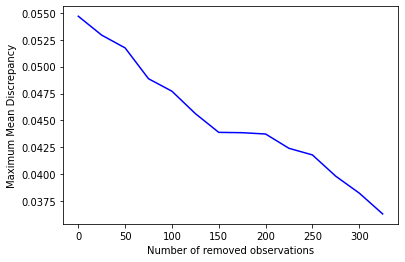

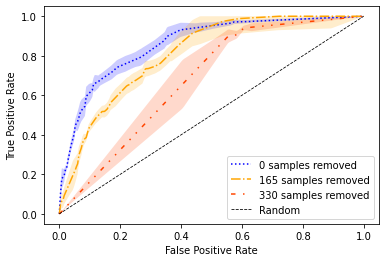

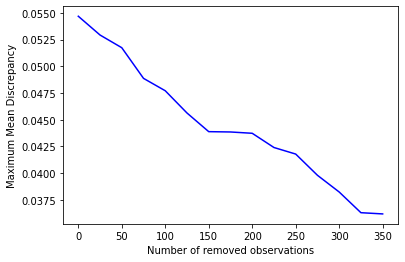

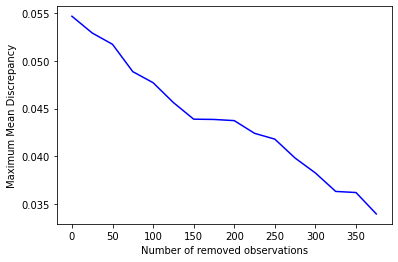

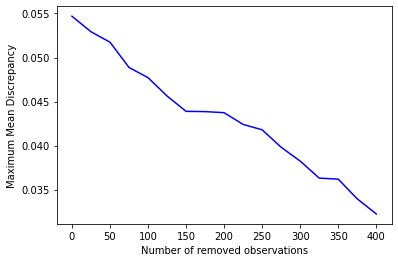

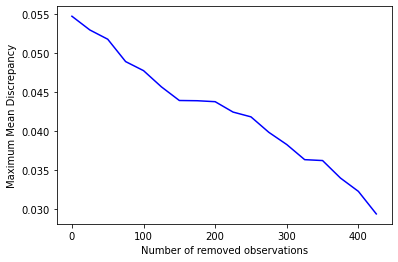

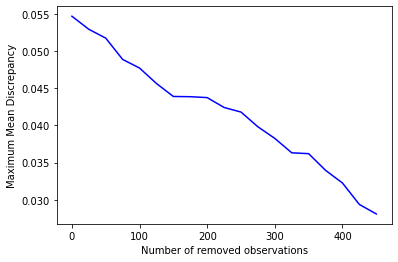

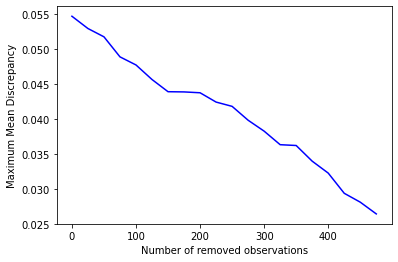

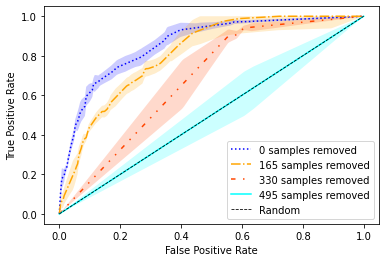

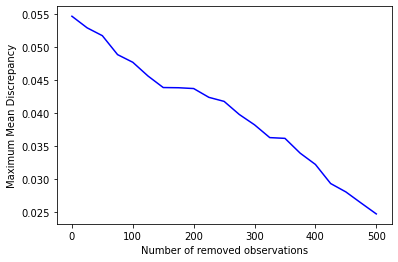

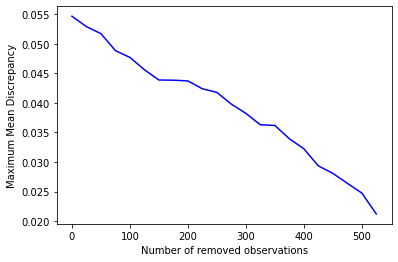

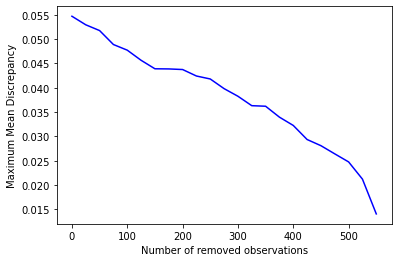

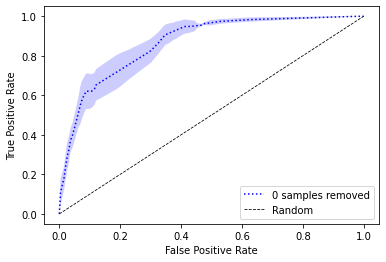

  0%|          | 0/115 [00:00<?, ?it/s]

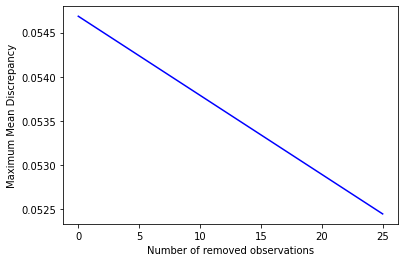

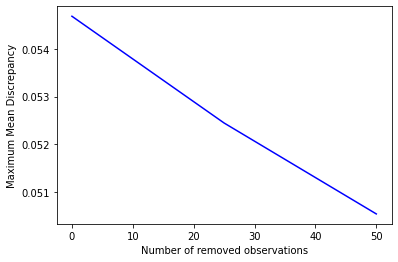

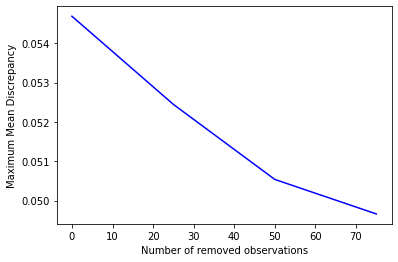

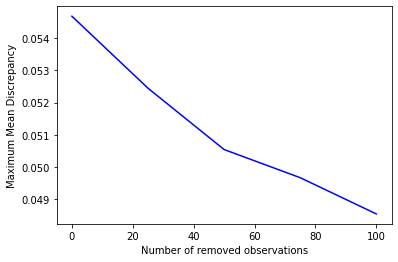

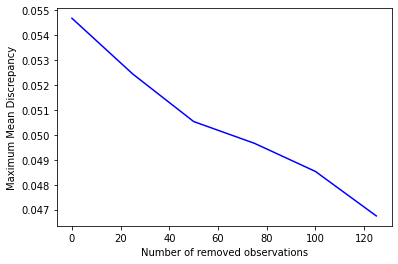

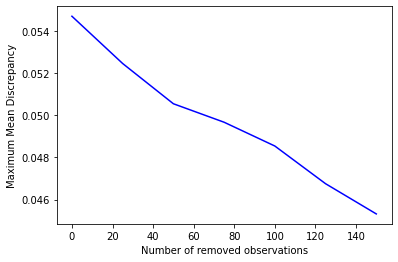

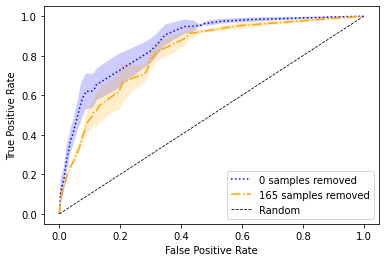

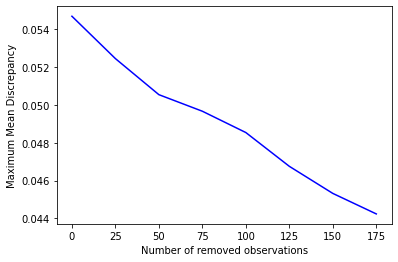

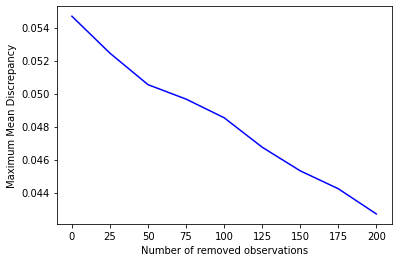

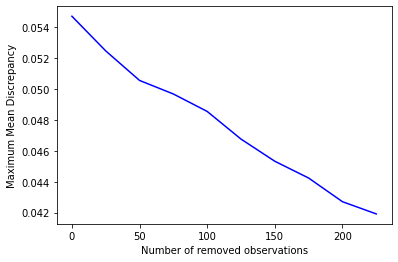

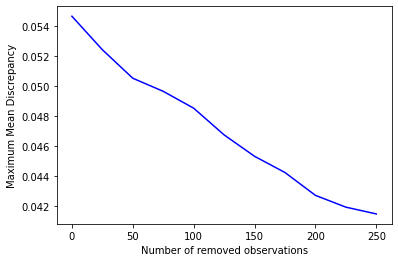

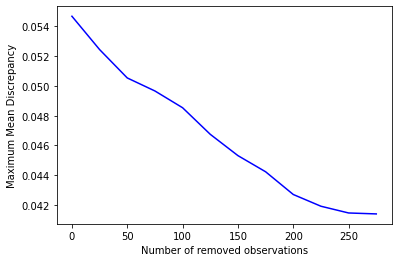

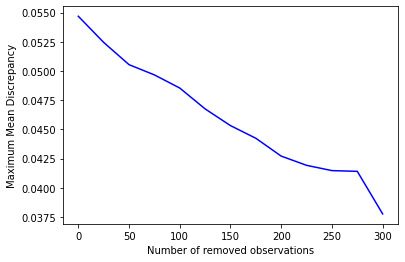

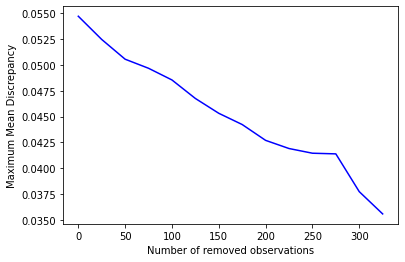

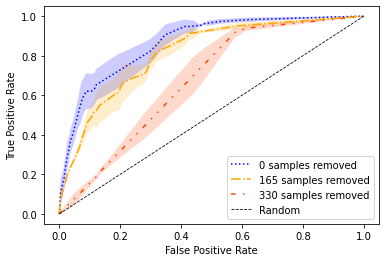

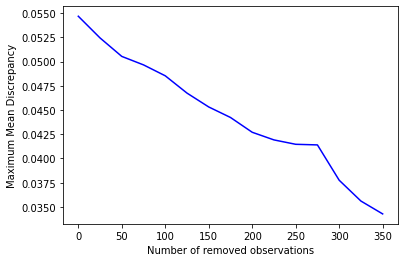

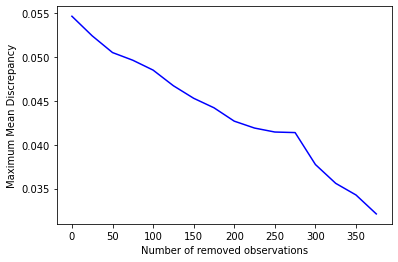

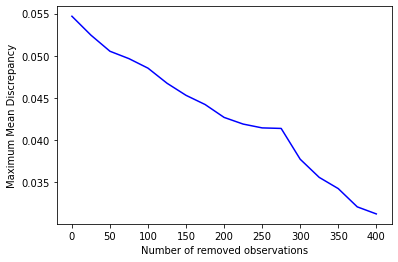

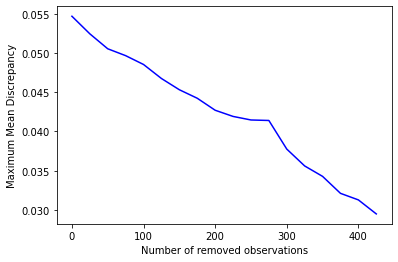

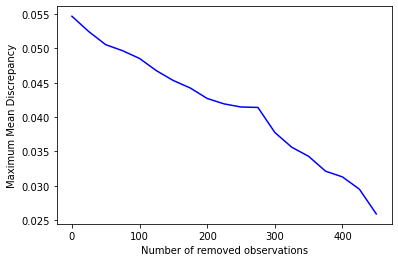

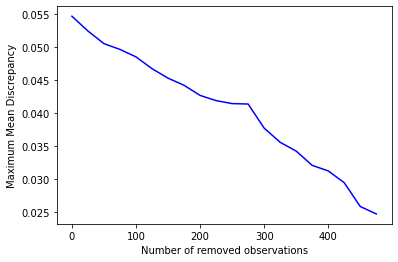

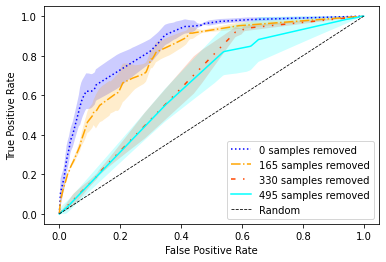

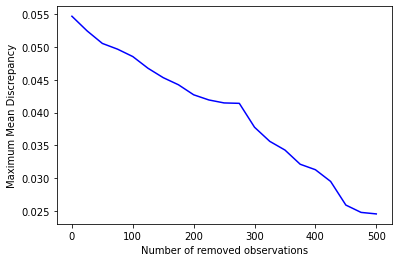

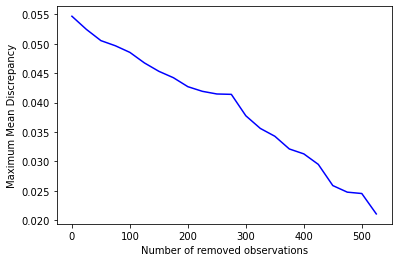

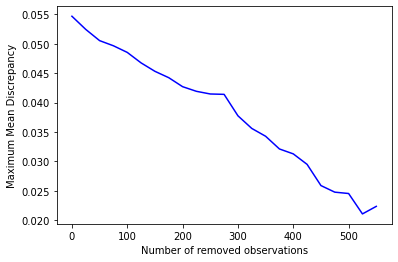

In [170]:
number_of_mrs = 5
mrs_list = []
drop = 5
number_of_splits = 5
cv = 5
test_size = 0.3
number_of_iterations = int(len(scaled_allensbach[scaled_allensbach['label'] == 1]) / drop) 
mmd_iteration = 700

for _ in tqdm(range(number_of_mrs)):
    _, _, mrs, _, _ = repeated_MRS(scaled_allensbach, allensbach_columns, 
                                                         number_of_splits=number_of_splits,
                            n_drop=drop, test_size=test_size, cv=cv, directory='',
                                                 number_of_iterations=number_of_iterations)
    mrs_list.append(mrs)

### Save MRS list

In [171]:
anonym_list = []
for mrs in mrs_list:
    mrs[allensbach_columns] = allensbach_scaler.inverse_transform(mrs[allensbach_columns])
    anonym_list.append(mrs[['Resilienz', 'Wahlteilnahme']])
all_mrs_elements = pd.concat(anonym_list)

In [172]:
pickle.dump(all_mrs_elements, open("results/all_mrs_elements", 'wb'))

### Load MRS list

In [173]:
all_mrs_elements = pickle.load(open("results/all_mrs_elements", 'rb'))

<ipython-input-181-5f0a15e9b85d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allensbach_without_gbs[value] = round(allensbach_without_gbs[value], 6)
<ipython-input-181-5f0a15e9b85d>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allensbach_gbs[value] = round(allensbach_gbs[value], 6)


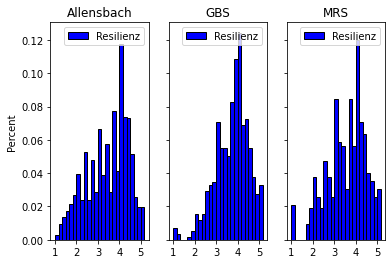

In [181]:
from scipy.stats import norm
allensbach_gbs = allensbach[allensbach['label'] == 1]
allensbach_without_gbs = allensbach[allensbach['label'] == 0]
bins = []
for i in range(6, 32):
    bins.append(round(i/6, 6))

value = 'Resilienz'
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)

weights_gbs = np.ones_like(allensbach_gbs[value]) / len(allensbach_gbs[value])
weights_mrs = np.ones_like(all_mrs_elements[value]) / len(all_mrs_elements[value])
weights_allensbach = np.ones_like(allensbach_without_gbs[value]) / len(allensbach_without_gbs[value])


allensbach_without_gbs[value] = round(allensbach_without_gbs[value], 6)
allensbach_without_gbs.plot.hist(y=value, bins=bins, ax=ax1, weights=weights_allensbach, ec='black')

allensbach_gbs[value] = round(allensbach_gbs[value], 6)
allensbach_gbs.plot.hist(y=value, bins=bins, ax=ax2, weights=weights_gbs, ec='black')

all_mrs_elements[value] = round(all_mrs_elements[value], 6)
all_mrs_elements.plot.hist(y=value, bins=bins, ax=ax3, weights=weights_mrs, ec='black')

ax2.set_title('GBS')
ax3.set_title('MRS')
ax1.set_title('Allensbach')
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_ylabel('Percent')

file_directory = os.path.join(os.getcwd(), "final_results/statistic/")
os.makedirs(file_directory, exist_ok=True)
f.savefig(file_directory + f'/{value}_histogram.pdf')
f.show()

### Plot cumulative distribution function

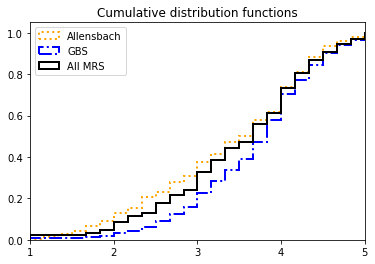

In [175]:
f, ax = plt.subplots(1, 1, sharey=True, sharex=True)

ax.hist(allensbach_without_gbs['Resilienz'], bins=bins, density=True, histtype='step',
                           cumulative=True, label='Allensbach', color='orange', linewidth=2,
       linestyle=':')
ax.hist(allensbach_gbs['Resilienz'], bins=bins,  density=True, histtype='step',
                           cumulative=True, color='blue', linestyle='-.', label='GBS', linewidth=2)
ax.hist(all_mrs_elements['Resilienz'], bins=bins, density=True, histtype='step',
                           cumulative=True, color='black', linestyle='-', label='All MRS', linewidth=2)

ax.legend(loc="upper left")
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_title('Cumulative distribution functions')
plt.xlim(1, 5)
plt.savefig(file_directory + f'/{value}_comulative_density.pdf')

plt.show()

In [176]:
y, X = dmatrices('Wahlteilnahme ~ Resilienz', data=allensbach_gbs, return_type='dataframe')
model_gbs = sm.Logit(y, X)
results_gbs = model_gbs.fit() 

restricted_model_gbs = sm.Logit(y, X.drop(columns='Resilienz'))
restricted_results_gbs = restricted_model_gbs.fit() 
 
y, X = dmatrices('Wahlteilnahme ~ Resilienz', data=all_mrs_elements, return_type='dataframe')
model_all = sm.Logit(y, X)
results_all = model_all.fit() 

restricted_model_all = sm.Logit(y, X.drop(columns='Resilienz'))
restricted_results_all = restricted_model_all.fit() 

Optimization terminated successfully.
         Current function value: 0.198294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.207567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210465
         Iterations 7


In [177]:
results_gbs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Wahlteilnahme   No. Observations:                  579
Model:                          Logit   Df Residuals:                      577
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Aug 2021   Pseudo R-squ.:                0.002392
Time:                        13:59:24   Log-Likelihood:                -114.81
converged:                       True   LL-Null:                       -115.09
Covariance Type:            nonrobust   LLR p-value:                    0.4581
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2887      0.880      2.602      0.009       0.565       4.013
Resilienz      0.1807      0.241      0.751      0.453      -0.291       0.652
==============================================================================
"""

### Create mean models

### Likelihood-ratio test GBS

In [178]:
loglikelihood_full = results_gbs.llf
loglikelihood_restr = restricted_results_gbs.llf
lrstat = -2*(loglikelihood_restr - loglikelihood_full)
lr_pvalue_gbs = stats.chi2.sf(lrstat, df=1)

### Log Likelihood test MRS list

In [179]:
loglikelihood_full = results_all.llf
loglikelihood_restr = restricted_results_all.llf
lrstat = -2*(loglikelihood_restr - loglikelihood_full)
lr_pvalue_all = stats.chi2.sf(lrstat, df=1)

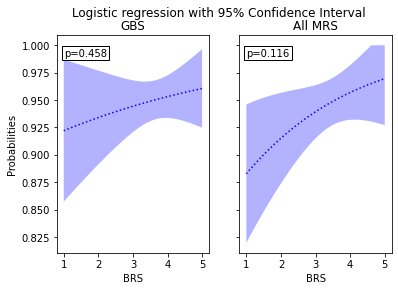

In [182]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
f.suptitle('Logistic regression with 95% Confidence Interval')
ax1.set_title(f'GBS')
ax1.set_ylabel('Probabilities')
ax1.set_xlabel('BRS')
ax1.set_xticks([1, 2, 3, 4, 5])

intercept_gbs, slope_gbs = results_gbs.params
x_line = np.linspace(1, 5, 200)
x = allensbach_gbs['Resilienz']
y = allensbach_gbs['Wahlteilnahme']
log_odds  = slope_gbs * x_line + intercept_gbs
y_line = 1 / (1+ np.exp(-log_odds))
y_model = results_gbs.predict()
x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 1                             # number of parameters
dof = n - m  
t = stats.t.ppf(0.975, dof)
residual = y - y_model
std_error = (np.sum(residual**2) / dof)**.5
# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
ci_high = [1 if i>1 else i for i in y_line + ci]
ax1.plot(x_line, y_line)
ax1.fill_between(x_line, ci_high, y_line - ci, alpha=0.3)

intercept_all, slope_all = results_all.params
x = all_mrs_elements['Resilienz']
y = all_mrs_elements['Wahlteilnahme']
log_odds  = slope_all * x_line + intercept_all
y_line = 1 / (1 + np.exp(-log_odds))
y_model = results_all.predict()
x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 1                             # number of parameters
dof = n - m  
t = stats.t.ppf(0.975, dof)
residual = y - y_model
std_error = (np.sum(residual**2) / dof)**.5
# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
ci_low = y_line - ci
ci_high = [1 if i>1 else i for i in y_line + ci]
ax2.set_title('All MRS')
ax2.set_xlabel('BRS');
ax2.plot(x_line, y_line)
ax2.fill_between(x_line, ci_low, ci_high, alpha=0.3)

# Show the plot
ax1.text(1, 0.99, f'p={round(lr_pvalue_gbs, 3)}',
        bbox=dict(facecolor='none', edgecolor='black', pad=2))
ax2.text(1, 0.99, f'p={round(lr_pvalue_all, 3)}', 
         bbox=dict(facecolor='none', edgecolor='black', pad=2))
f.savefig(file_directory + '/glm_brs_wahlteilnahme.pdf')
f.show()